In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from torchvision.utils import make_grid
from autoencoder import *
from torch.optim import Adam
import json
from torchsummary import summary

# Load in Data Functions and Paths

In [2]:
path = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Your initial path
new_path = os.path.dirname(path)  # Remove the last folder

# Add the root directory (PARCTorch) to the system path
sys.path.append(new_path)
from data.normalization import compute_min_max

data_dirs = [
    "/project/vil_baek/data/physics/PARCTorch/HMX/train",
    "/project/vil_baek/data/physics/PARCTorch/HMX/test",
]
output_file = new_path + "/data/hmx_min_max.json"
compute_min_max(data_dirs, output_file)

from torch.utils.data import DataLoader, random_split
import logging
from data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
)
from utilities.viz import visualize_channels, save_gifs_with_ground_truth

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

# Example configuration for HMX dataset
data_dir_train = "/project/vil_baek/data/physics/PARCTorch/HMX/train"  # Replace with your actual train directory path
data_dir_test = "/project/vil_baek/data/physics/PARCTorch/HMX/test"  # Replace with your actual test directory path

# Path to the min_max.json file
min_max_path = os.path.join(new_path, "data", "hmx_min_max.json")  # Correct path

Calculating channel-wise min and max values for normalization...
Current working directory: /sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC/autoencoder
Total files to process: 133
Processed 100/133 files.
Processed 133/133 files.
Channel-wise min values: [300.0, -1186907500.0, 0.0, -1995.0012, -5521.5503]
Channel-wise max values: [5000.0, 69721220000.0, 1.0, 7184.0073, 5215.695]
Min and max values saved to '/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/data/hmx_min_max.json'.


# Create Data Loader for Training

In [3]:
n_ts = 2
batch_size = 32
validation_split = 0.05  # 20% for validation

# Initialize the dataset
train_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_train],
    future_steps=n_ts-1,
    min_max_path=min_max_path,
    vflip_prob=0.5,
)

# Calculate the size of the validation set
validation_size = int(len(train_dataset) * validation_split)
train_size = len(train_dataset) - validation_size

# Perform the split
train_subset, val_subset = random_split(train_dataset, [train_size, validation_size])

# Create DataLoader for training and validation datasets
train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the training data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle validation data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

2025-05-21 09:43:31,580 [INFO] Starting data validation...
2025-05-21 09:43:31,585 [INFO] Validating .npy files...
Validating files: 100%|██████████| 100/100 [00:00<00:00, 495.33it/s]
2025-05-21 09:43:31,794 [INFO] Data validation completed successfully.
2025-05-21 09:43:31,796 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 100/100 [00:00<00:00, 387.78it/s]
2025-05-21 09:43:32,059 [INFO] Total samples in dataset: 1400


# Training

In [4]:
# where to save weights
save_path="/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC/autoencoder"
weights_name="MSE_sigmoid_decoder_LR_8_5_1_2_2"

# model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize encoder/decoder
layer_sizes = [1, 2]
latent_dim = 2

encoder_T = Encoder(layers=layer_sizes, latent_dim=latent_dim)
encoder_P = Encoder(layers=layer_sizes, latent_dim=latent_dim)
encoder_M = Encoder(layers=layer_sizes, latent_dim=latent_dim)

decoder_T = Decoder(layers=layer_sizes, latent_dim=latent_dim)
decoder_P = Decoder(layers=layer_sizes, latent_dim=latent_dim)
decoder_M = Decoder(layers=layer_sizes, latent_dim=latent_dim)

AE_T = Autoencoder(encoder_T, decoder_T)
AE_P = Autoencoder(encoder_P, decoder_P)
AE_M = Autoencoder(encoder_M, decoder_M)

criterion_T = torch.nn.MSELoss().cuda()
criterion_P = torch.nn.MSELoss().cuda()
criterion_M = torch.nn.MSELoss().cuda()

optimizer_T = Adam(AE_T.parameters(), lr=1e-3)
optimizer_P = Adam(AE_P.parameters(), lr=1e-3)
optimizer_M = Adam(AE_M.parameters(), lr=1e-3)

scheduler_T = ReduceLROnPlateau(optimizer_T, mode='min', factor=0.8, patience=5, verbose=True)
scheduler_P = ReduceLROnPlateau(optimizer_P, mode='min', factor=0.8, patience=5, verbose=True)
scheduler_M = ReduceLROnPlateau(optimizer_M, mode='min', factor=0.8, patience=5, verbose=True)

model_T = ConvolutionalAutoencoder(AE_T, optimizer_T, device, save_path, f"{weights_name}_T")
model_P = ConvolutionalAutoencoder(AE_P, optimizer_P, device, save_path, f"{weights_name}_P")
model_M = ConvolutionalAutoencoder(AE_M, optimizer_M, device, save_path, f"{weights_name}_M")

/home/pdy2bw/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
epochs = 50

log_T = train_individual_autoencoder(model_T.network, optimizer_T, criterion_T, train_loader, val_loader, 
                             device=device, epochs=epochs, image_size=[128, 256], channel_index=0, 
                             scheduler=scheduler_T, noise_fn=add_random_noise, initial_max_noise=0.16, reduce_on=10,
                             save_path=save_path, weights_name=f"{weights_name}_T")

log_P = train_individual_autoencoder(model_P.network, optimizer_P, criterion_P, train_loader, val_loader, 
                             device=device, epochs=epochs, image_size=[128, 256], channel_index=1, 
                             scheduler=scheduler_P, noise_fn=add_random_noise, initial_max_noise=0.16, reduce_on=10,
                             save_path=save_path, weights_name=f"{weights_name}_P")

log_M = train_individual_autoencoder(model_M.network, optimizer_M, criterion_M, train_loader, val_loader, 
                             device=device, epochs=epochs, image_size=[128, 256], channel_index=2, 
                             scheduler=scheduler_M, noise_fn=add_random_noise, initial_max_noise=0.16, reduce_on=10,
                             save_path=save_path, weights_name=f"{weights_name}_M")


Epoch 1/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.71it/s]


Epoch 1: Training Loss: 0.2057 | Validation Loss: 0.2006

Epoch 2/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.75it/s]


Epoch 2: Training Loss: 0.1963 | Validation Loss: 0.1915

Epoch 3/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  9.14it/s]


Epoch 3: Training Loss: 0.1874 | Validation Loss: 0.1827

Epoch 4/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.91it/s]


Epoch 4: Training Loss: 0.1789 | Validation Loss: 0.1743

Epoch 5/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.65it/s]


Epoch 5: Training Loss: 0.1707 | Validation Loss: 0.1663

Epoch 6/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.50it/s]


Epoch 6: Training Loss: 0.1628 | Validation Loss: 0.1585

Epoch 7/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  9.12it/s]


Epoch 7: Training Loss: 0.1553 | Validation Loss: 0.1512

Epoch 8/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  9.17it/s]


Epoch 8: Training Loss: 0.1480 | Validation Loss: 0.1441

Epoch 9/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.75it/s]


Epoch 9: Training Loss: 0.1411 | Validation Loss: 0.1373

Epoch 10/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.80it/s]


Epoch 10: Training Loss: 0.0876 | Validation Loss: 0.0037

Epoch 11/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  9.10it/s]


Epoch 11: Training Loss: 0.0031 | Validation Loss: 0.0025

Epoch 12/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]


Epoch 12: Training Loss: 0.0031 | Validation Loss: 0.0024

Epoch 13/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.60it/s]


Epoch 13: Training Loss: 0.0030 | Validation Loss: 0.0023

Epoch 14/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  9.13it/s]


Epoch 14: Training Loss: 0.0029 | Validation Loss: 0.0022

Epoch 15/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.53it/s]


Epoch 15: Training Loss: 0.0028 | Validation Loss: 0.0021

Epoch 16/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.30it/s]


Epoch 16: Training Loss: 0.0026 | Validation Loss: 0.0020

Epoch 17/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.70it/s]


Epoch 17: Training Loss: 0.0025 | Validation Loss: 0.0019

Epoch 18/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.01it/s]


Epoch 18: Training Loss: 0.0024 | Validation Loss: 0.0019

Epoch 19/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]


Epoch 19: Training Loss: 0.0024 | Validation Loss: 0.0018

Epoch 20/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.02it/s]


Epoch 20: Training Loss: 0.0023 | Validation Loss: 0.0018

Epoch 21/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.48it/s]


Epoch 21: Training Loss: 0.0022 | Validation Loss: 0.0018

Epoch 22/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.54it/s]


Epoch 22: Training Loss: 0.0022 | Validation Loss: 0.0017

Epoch 23/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.98it/s]


Epoch 23: Training Loss: 0.0021 | Validation Loss: 0.0017

Epoch 24/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]


Epoch 24: Training Loss: 0.0021 | Validation Loss: 0.0017

Epoch 25/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.91it/s]


Epoch 25: Training Loss: 0.0020 | Validation Loss: 0.0017

Epoch 26/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.52it/s]


Epoch 26: Training Loss: 0.0020 | Validation Loss: 0.0017

Epoch 27/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.27it/s]


Epoch 27: Training Loss: 0.0020 | Validation Loss: 0.0017

Epoch 28/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.87it/s]


Epoch 28: Training Loss: 0.0019 | Validation Loss: 0.0017

Epoch 29/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.28it/s]


Epoch 29: Training Loss: 0.0019 | Validation Loss: 0.0017

Epoch 30/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.60it/s]


Epoch 30: Training Loss: 0.0018 | Validation Loss: 0.0015

Epoch 31/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.98it/s]


Epoch 31: Training Loss: 0.0017 | Validation Loss: 0.0015

Epoch 32/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.79it/s]


Epoch 32: Training Loss: 0.0017 | Validation Loss: 0.0015

Epoch 33/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.92it/s]


Epoch 33: Training Loss: 0.0016 | Validation Loss: 0.0015

Epoch 34/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.39it/s]


Epoch 34: Training Loss: 0.0016 | Validation Loss: 0.0015

Epoch 35/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  9.09it/s]


Epoch 35: Training Loss: 0.0016 | Validation Loss: 0.0015

Epoch 36/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.78it/s]


Epoch 36: Training Loss: 0.0015 | Validation Loss: 0.0015

Epoch 37/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.87it/s]


Epoch 37: Training Loss: 0.0015 | Validation Loss: 0.0015

Epoch 38/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.53it/s]


Epoch 38: Training Loss: 0.0014 | Validation Loss: 0.0015

Epoch 39/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.71it/s]


Epoch 39: Training Loss: 0.0014 | Validation Loss: 0.0015

Epoch 40/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.94it/s]


Epoch 40: Training Loss: 0.0013 | Validation Loss: 0.0013

Epoch 41/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.45it/s]


Epoch 41: Training Loss: 0.0012 | Validation Loss: 0.0013

Epoch 42/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.95it/s]


Epoch 42: Training Loss: 0.0012 | Validation Loss: 0.0013

Epoch 43/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.70it/s]


Epoch 43: Training Loss: 0.0011 | Validation Loss: 0.0012

Epoch 44/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.19it/s]


Epoch 44: Training Loss: 0.0011 | Validation Loss: 0.0012

Epoch 45/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.42it/s]


Epoch 45: Training Loss: 0.0011 | Validation Loss: 0.0012

Epoch 46/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.69it/s]


Epoch 46: Training Loss: 0.0010 | Validation Loss: 0.0012

Epoch 47/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.78it/s]


Epoch 47: Training Loss: 0.0010 | Validation Loss: 0.0012

Epoch 48/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.56it/s]


Epoch 48: Training Loss: 0.0009 | Validation Loss: 0.0012

Epoch 49/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.93it/s]


Epoch 49: Training Loss: 0.0009 | Validation Loss: 0.0012

Epoch 50/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.78it/s]


Epoch 50: Training Loss: 0.0009 | Validation Loss: 0.0010
Model weights saved to /sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC/autoencoder/MSE_sigmoid_decoder_LR_8_5_1_2_2_T_50.pth

Epoch 1/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.35it/s]


Epoch 1: Training Loss: 0.1166 | Validation Loss: 0.0842

Epoch 2/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.65it/s]


Epoch 2: Training Loss: 0.0400 | Validation Loss: 0.0117

Epoch 3/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.80it/s]


Epoch 3: Training Loss: 0.0079 | Validation Loss: 0.0073

Epoch 4/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.61it/s]


Epoch 4: Training Loss: 0.0072 | Validation Loss: 0.0067

Epoch 5/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.22it/s]


Epoch 5: Training Loss: 0.0066 | Validation Loss: 0.0059

Epoch 6/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.36it/s]


Epoch 6: Training Loss: 0.0057 | Validation Loss: 0.0048

Epoch 7/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.66it/s]


Epoch 7: Training Loss: 0.0046 | Validation Loss: 0.0037

Epoch 8/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.76it/s]


Epoch 8: Training Loss: 0.0035 | Validation Loss: 0.0032

Epoch 9/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.96it/s]


Epoch 9: Training Loss: 0.0025 | Validation Loss: 0.0031

Epoch 10/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.80it/s]


Epoch 10: Training Loss: 0.0016 | Validation Loss: 0.0027

Epoch 11/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.23it/s]


Epoch 11: Training Loss: 0.0011 | Validation Loss: 0.0030

Epoch 12/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.35it/s]


Epoch 12: Training Loss: 0.0008 | Validation Loss: 0.0033

Epoch 13/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.27it/s]


Epoch 13: Training Loss: 0.0007 | Validation Loss: 0.0036

Epoch 14/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.24it/s]


Epoch 14: Training Loss: 0.0006 | Validation Loss: 0.0038

Epoch 15/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.41it/s]


Epoch 15: Training Loss: 0.0006 | Validation Loss: 0.0040

Epoch 16/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.97it/s]


Epoch 16: Training Loss: 0.0006 | Validation Loss: 0.0041

Epoch 17/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.58it/s]


Epoch 17: Training Loss: 0.0006 | Validation Loss: 0.0041

Epoch 18/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.89it/s]


Epoch 18: Training Loss: 0.0005 | Validation Loss: 0.0042

Epoch 19/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.51it/s]


Epoch 19: Training Loss: 0.0005 | Validation Loss: 0.0042

Epoch 20/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.82it/s]


Epoch 20: Training Loss: 0.0006 | Validation Loss: 0.0033

Epoch 21/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.63it/s]


Epoch 21: Training Loss: 0.0005 | Validation Loss: 0.0032

Epoch 22/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.33it/s]


Epoch 22: Training Loss: 0.0005 | Validation Loss: 0.0031

Epoch 23/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.57it/s]


Epoch 23: Training Loss: 0.0005 | Validation Loss: 0.0031

Epoch 24/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.52it/s]


Epoch 24: Training Loss: 0.0005 | Validation Loss: 0.0031

Epoch 25/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.00it/s]


Epoch 25: Training Loss: 0.0005 | Validation Loss: 0.0031

Epoch 26/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.86it/s]


Epoch 26: Training Loss: 0.0005 | Validation Loss: 0.0031

Epoch 27/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.73it/s]


Epoch 27: Training Loss: 0.0005 | Validation Loss: 0.0030

Epoch 28/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s]


Epoch 28: Training Loss: 0.0005 | Validation Loss: 0.0031

Epoch 29/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]


Epoch 29: Training Loss: 0.0005 | Validation Loss: 0.0030

Epoch 30/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.48it/s]


Epoch 30: Training Loss: 0.0005 | Validation Loss: 0.0023

Epoch 31/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.81it/s]


Epoch 31: Training Loss: 0.0005 | Validation Loss: 0.0022

Epoch 32/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.36it/s]


Epoch 32: Training Loss: 0.0005 | Validation Loss: 0.0022

Epoch 33/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.91it/s]


Epoch 33: Training Loss: 0.0005 | Validation Loss: 0.0022

Epoch 34/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.72it/s]


Epoch 34: Training Loss: 0.0005 | Validation Loss: 0.0022

Epoch 35/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.49it/s]


Epoch 35: Training Loss: 0.0005 | Validation Loss: 0.0021

Epoch 36/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]


Epoch 36: Training Loss: 0.0005 | Validation Loss: 0.0021

Epoch 37/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.83it/s]


Epoch 37: Training Loss: 0.0005 | Validation Loss: 0.0021

Epoch 38/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.73it/s]


Epoch 38: Training Loss: 0.0005 | Validation Loss: 0.0021

Epoch 39/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.57it/s]


Epoch 39: Training Loss: 0.0005 | Validation Loss: 0.0021

Epoch 40/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.42it/s]


Epoch 40: Training Loss: 0.0005 | Validation Loss: 0.0016

Epoch 41/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.16it/s]


Epoch 41: Training Loss: 0.0005 | Validation Loss: 0.0015

Epoch 42/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]


Epoch 42: Training Loss: 0.0005 | Validation Loss: 0.0015

Epoch 43/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.29it/s]


Epoch 43: Training Loss: 0.0004 | Validation Loss: 0.0015

Epoch 44/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.99it/s]


Epoch 44: Training Loss: 0.0004 | Validation Loss: 0.0015

Epoch 45/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.72it/s]


Epoch 45: Training Loss: 0.0004 | Validation Loss: 0.0015

Epoch 46/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.68it/s]


Epoch 46: Training Loss: 0.0004 | Validation Loss: 0.0014

Epoch 47/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.74it/s]


Epoch 47: Training Loss: 0.0004 | Validation Loss: 0.0015

Epoch 48/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.43it/s]


Epoch 48: Training Loss: 0.0004 | Validation Loss: 0.0015

Epoch 49/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.25it/s]


Epoch 49: Training Loss: 0.0004 | Validation Loss: 0.0015

Epoch 50/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.08it/s]


Epoch 50: Training Loss: 0.0004 | Validation Loss: 0.0011
Model weights saved to /sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC/autoencoder/MSE_sigmoid_decoder_LR_8_5_1_2_2_P_50.pth

Epoch 1/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.35it/s]


Epoch 1: Training Loss: 0.2583 | Validation Loss: 0.2529

Epoch 2/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.54it/s]


Epoch 2: Training Loss: 0.2478 | Validation Loss: 0.2420

Epoch 3/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.62it/s]


Epoch 3: Training Loss: 0.2365 | Validation Loss: 0.2302

Epoch 4/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.17it/s]


Epoch 4: Training Loss: 0.2255 | Validation Loss: 0.2200

Epoch 5/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.65it/s]


Epoch 5: Training Loss: 0.2156 | Validation Loss: 0.2105

Epoch 6/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.65it/s]


Epoch 6: Training Loss: 0.2063 | Validation Loss: 0.2014

Epoch 7/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.64it/s]


Epoch 7: Training Loss: 0.1974 | Validation Loss: 0.1928

Epoch 8/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]


Epoch 8: Training Loss: 0.1890 | Validation Loss: 0.1846

Epoch 9/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]


Epoch 9: Training Loss: 0.1809 | Validation Loss: 0.1767

Epoch 10/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.40it/s]


Epoch 10: Training Loss: 0.1732 | Validation Loss: 0.1691

Epoch 11/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.64it/s]


Epoch 11: Training Loss: 0.1658 | Validation Loss: 0.1619

Epoch 12/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.47it/s]


Epoch 12: Training Loss: 0.1588 | Validation Loss: 0.1550

Epoch 13/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.68it/s]


Epoch 13: Training Loss: 0.1520 | Validation Loss: 0.1484

Epoch 14/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]


Epoch 14: Training Loss: 0.1456 | Validation Loss: 0.1421

Epoch 15/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.17it/s]


Epoch 15: Training Loss: 0.1394 | Validation Loss: 0.1361

Epoch 16/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.54it/s]


Epoch 16: Training Loss: 0.1335 | Validation Loss: 0.1303

Epoch 17/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.30it/s]


Epoch 17: Training Loss: 0.1278 | Validation Loss: 0.1248

Epoch 18/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.15it/s]


Epoch 18: Training Loss: 0.1224 | Validation Loss: 0.1196

Epoch 19/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.00it/s]


Epoch 19: Training Loss: 0.1174 | Validation Loss: 0.1147

Epoch 20/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.56it/s]


Epoch 20: Training Loss: 0.1125 | Validation Loss: 0.1099

Epoch 21/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.20it/s]


Epoch 21: Training Loss: 0.1078 | Validation Loss: 0.1053

Epoch 22/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.73it/s]


Epoch 22: Training Loss: 0.1034 | Validation Loss: 0.1010

Epoch 23/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.33it/s]


Epoch 23: Training Loss: 0.0991 | Validation Loss: 0.0969

Epoch 24/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]


Epoch 24: Training Loss: 0.0951 | Validation Loss: 0.0929

Epoch 25/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.12it/s]


Epoch 25: Training Loss: 0.0913 | Validation Loss: 0.0892

Epoch 26/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]


Epoch 26: Training Loss: 0.0876 | Validation Loss: 0.0857

Epoch 27/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.89it/s]


Epoch 27: Training Loss: 0.0841 | Validation Loss: 0.0822

Epoch 28/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  9.06it/s]


Epoch 28: Training Loss: 0.0808 | Validation Loss: 0.0790

Epoch 29/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.92it/s]


Epoch 29: Training Loss: 0.0776 | Validation Loss: 0.0759

Epoch 30/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.92it/s]


Epoch 30: Training Loss: 0.0746 | Validation Loss: 0.0730

Epoch 31/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.46it/s]


Epoch 31: Training Loss: 0.0717 | Validation Loss: 0.0701

Epoch 32/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.89it/s]


Epoch 32: Training Loss: 0.0689 | Validation Loss: 0.0674

Epoch 33/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.68it/s]


Epoch 33: Training Loss: 0.0663 | Validation Loss: 0.0649

Epoch 34/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.92it/s]


Epoch 34: Training Loss: 0.0638 | Validation Loss: 0.0624

Epoch 35/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]


Epoch 35: Training Loss: 0.0614 | Validation Loss: 0.0601

Epoch 36/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.53it/s]


Epoch 36: Training Loss: 0.0591 | Validation Loss: 0.0579

Epoch 37/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.53it/s]


Epoch 37: Training Loss: 0.0570 | Validation Loss: 0.0558

Epoch 38/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.31it/s]


Epoch 38: Training Loss: 0.0549 | Validation Loss: 0.0537

Epoch 39/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.99it/s]


Epoch 39: Training Loss: 0.0529 | Validation Loss: 0.0518

Epoch 40/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.51it/s]


Epoch 40: Training Loss: 0.0510 | Validation Loss: 0.0499

Epoch 41/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.22it/s]


Epoch 41: Training Loss: 0.0492 | Validation Loss: 0.0482

Epoch 42/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.57it/s]


Epoch 42: Training Loss: 0.0474 | Validation Loss: 0.0465

Epoch 43/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.80it/s]


Epoch 43: Training Loss: 0.0458 | Validation Loss: 0.0448

Epoch 44/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.98it/s]


Epoch 44: Training Loss: 0.0442 | Validation Loss: 0.0433

Epoch 45/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.23it/s]


Epoch 45: Training Loss: 0.0426 | Validation Loss: 0.0418

Epoch 46/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]


Epoch 46: Training Loss: 0.0412 | Validation Loss: 0.0404

Epoch 47/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.45it/s]


Epoch 47: Training Loss: 0.0398 | Validation Loss: 0.0390

Epoch 48/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.36it/s]


Epoch 48: Training Loss: 0.0385 | Validation Loss: 0.0377

Epoch 49/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  8.46it/s]


Epoch 49: Training Loss: 0.0372 | Validation Loss: 0.0365

Epoch 50/50


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.94it/s]

Epoch 50: Training Loss: 0.0359 | Validation Loss: 0.0352
Model weights saved to /sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC/autoencoder/MSE_sigmoid_decoder_LR_8_5_1_2_2_M_50.pth


# Load in Weights

In [12]:
# define model
# model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize encoder/decoder
layer_sizes = [1, 2]
latent_dim = 4

encoder_T = Encoder(layers=layer_sizes, latent_dim=latent_dim)
encoder_P = Encoder(layers=layer_sizes, latent_dim=latent_dim)
encoder_M = Encoder(layers=layer_sizes, latent_dim=latent_dim)

decoder_T = Decoder(layers=layer_sizes, latent_dim=latent_dim)
decoder_P = Decoder(layers=layer_sizes, latent_dim=latent_dim)
decoder_M = Decoder(layers=layer_sizes, latent_dim=latent_dim)

# Initialize autoencoder
autoencoder = Autoencoder_separate(encoder_T, encoder_P, encoder_M, decoder_T, decoder_P, decoder_M).to(device)

In [13]:
# load weights into model
weights_path = "notpopped_dec_vertflip_layers_1_2_latent_4_MSE_DE_Nmax16_nrf8_redon10_LRplateau_e3_factor8_pat10"
n_epochs = 500

# Load individual model weights
ae_T_state_dict = torch.load(f"{weights_path}_T_{n_epochs}.pth")
ae_P_state_dict = torch.load(f"{weights_path}_T_{n_epochs}.pth")
ae_M_state_dict = torch.load(f"{weights_path}_T_{n_epochs}.pth")

# Manually load submodule weights
autoencoder.encoderT.load_state_dict({k.replace("encoder.", ""): v for k, v in ae_T_state_dict.items() if k.startswith("encoder.")})
autoencoder.decoderT.load_state_dict({k.replace("decoder.", ""): v for k, v in ae_T_state_dict.items() if k.startswith("decoder.")})

autoencoder.encoderP.load_state_dict({k.replace("encoder.", ""): v for k, v in ae_P_state_dict.items() if k.startswith("encoder.")})
autoencoder.decoderP.load_state_dict({k.replace("decoder.", ""): v for k, v in ae_P_state_dict.items() if k.startswith("decoder.")})

autoencoder.encoderM.load_state_dict({k.replace("encoder.", ""): v for k, v in ae_M_state_dict.items() if k.startswith("encoder.")})
autoencoder.decoderM.load_state_dict({k.replace("decoder.", ""): v for k, v in ae_M_state_dict.items() if k.startswith("decoder.")})

# Set model to eval mode
autoencoder.eval()

/tmp/ipykernel_241185/1385226711.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae_T_state_dict = torch.load(f"{weights_path}_T_{n_epochs}.pth")
/tmp/ipykernel_241185/1

Autoencoder_separate(
  (encoderT): Encoder(
    (net): Sequential(
      (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (encoderP): Encoder(
    (net): Sequential(
      (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (encoderM): Encoder(
    (net): Sequential(
      (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (decoderT): Decoder(
    (conv): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): Upsample(scale_factor=2.0, mode='bilinear')
      (4): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1

# Make Predictions

In [14]:
# load in test dataset with full 15ts sequence
n_channels = 3
n_ts = 15

# Create test dataset
# ic, t0, t1, gt
test_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test],
    future_steps=n_ts-1,
    min_max_path=min_max_path,
)

2025-05-21 09:45:00,291 [INFO] Starting data validation...
2025-05-21 09:45:00,295 [INFO] Validating .npy files...
Validating files: 100%|██████████| 33/33 [00:00<00:00, 644.98it/s]
2025-05-21 09:45:00,350 [INFO] Data validation completed successfully.
2025-05-21 09:45:00,352 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 33/33 [00:00<00:00, 517.72it/s]
2025-05-21 09:45:00,421 [INFO] Total samples in dataset: 33


In [15]:
sample_id = 0
ic, _, _, target = test_dataset[sample_id]
ic = ic[:n_channels, ...]
target = target[:, :n_channels, ...]
print(ic.shape, target.shape)
all_test_images = torch.concat((ic.unsqueeze(0), target))
print(all_test_images.shape)

torch.Size([3, 128, 256]) torch.Size([14, 3, 128, 256])
torch.Size([15, 3, 128, 256])


In [16]:
# Initialize list to store all reconstructed images
all_reconstructed_images = []

for i in range(n_ts):
    with torch.no_grad():
        img = all_test_images[i, ...].unsqueeze(0).to(device)  # Move image to same device
        reconstructed_img = autoencoder(img)
    all_reconstructed_images.append(reconstructed_img.cpu())  # move output back to CPU

# Concatenate all batches to create single tensors
all_reconstructed_images = torch.cat(all_reconstructed_images, dim=0)

In [17]:
all_test_images.shape, all_reconstructed_images.shape

(torch.Size([15, 3, 128, 256]), torch.Size([15, 3, 128, 256]))

# Visualizations

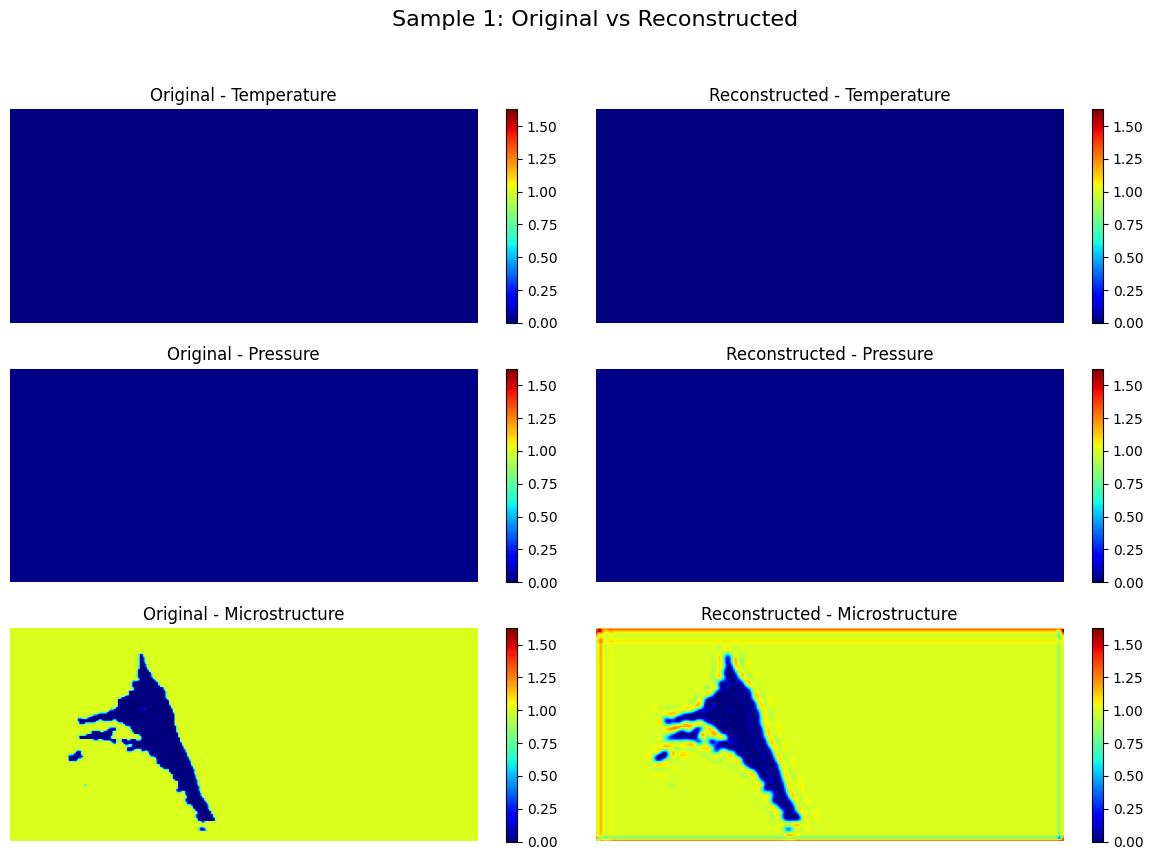

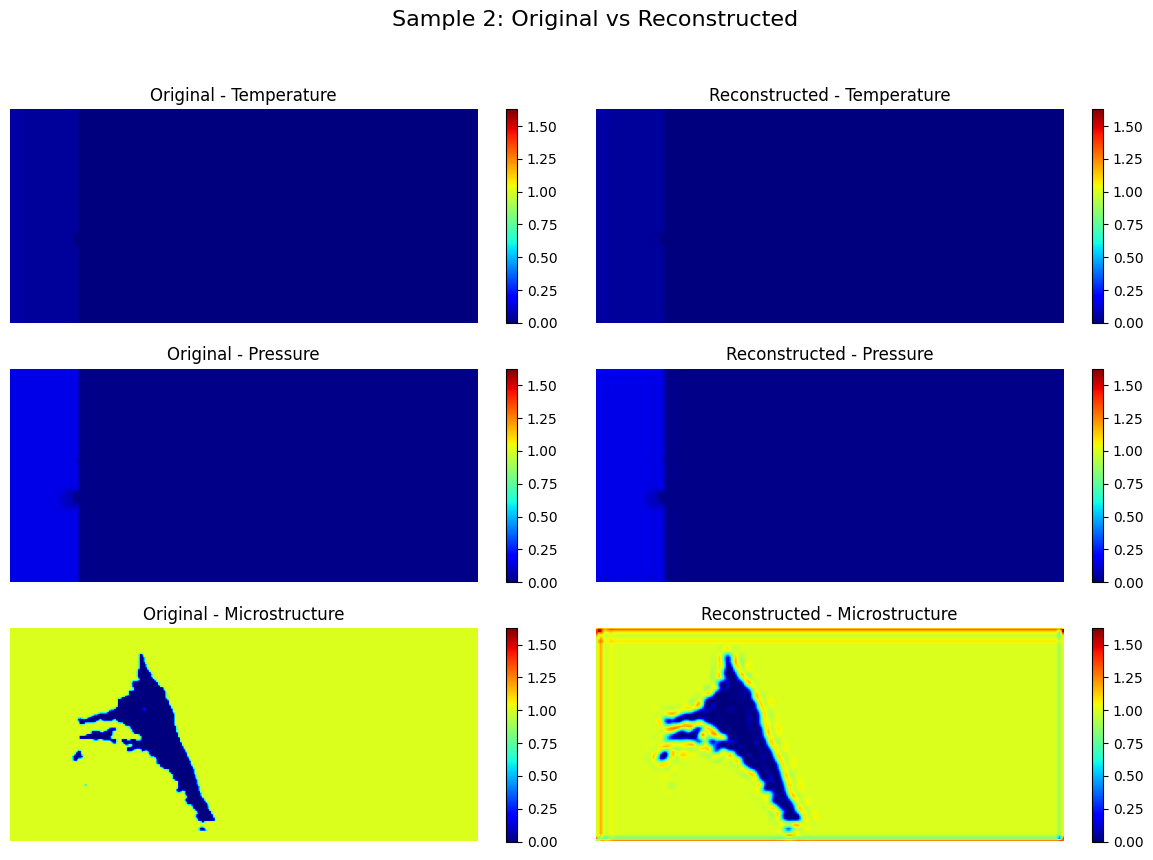

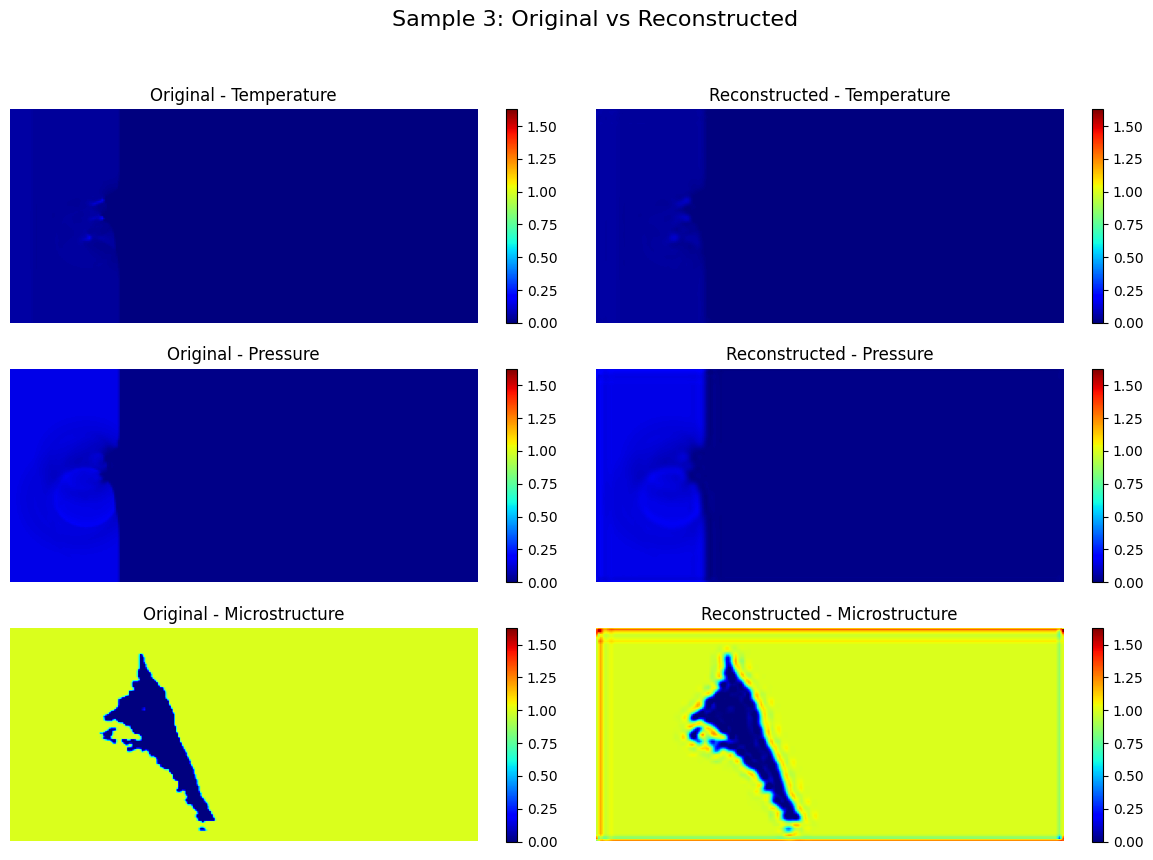

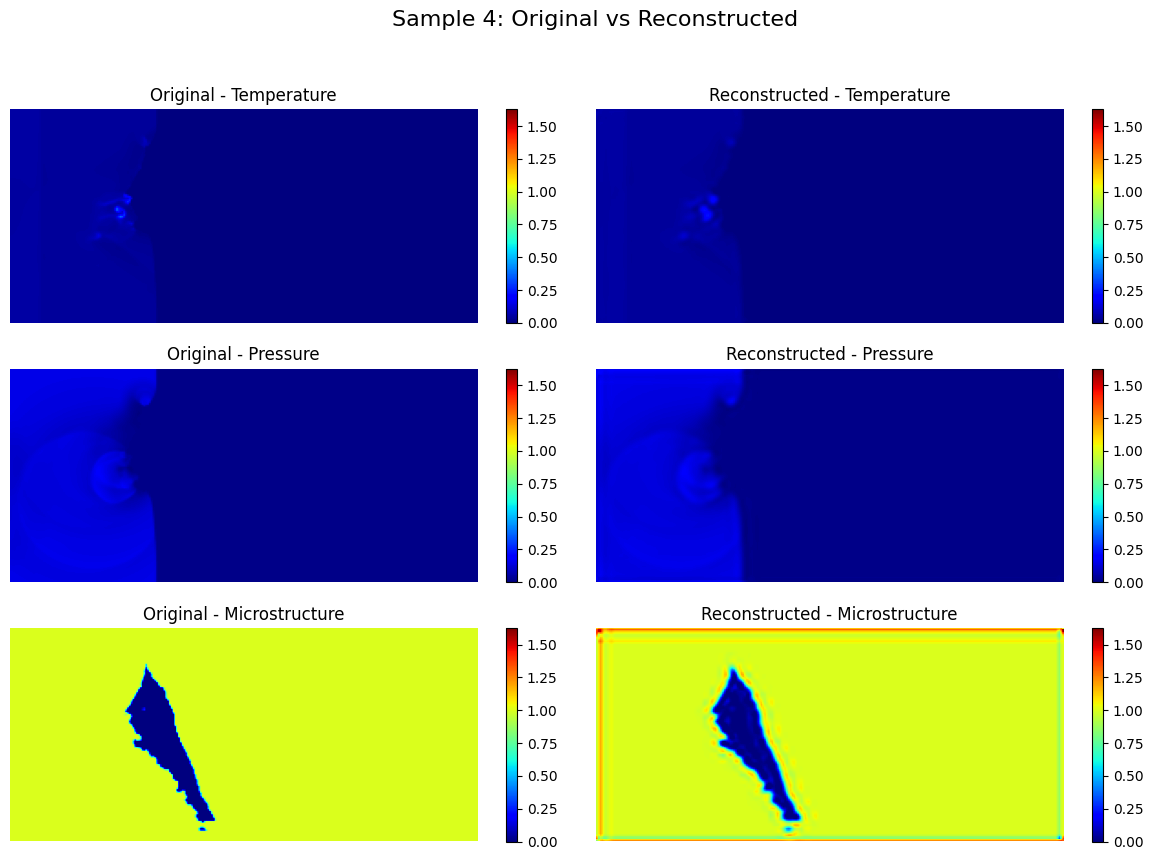

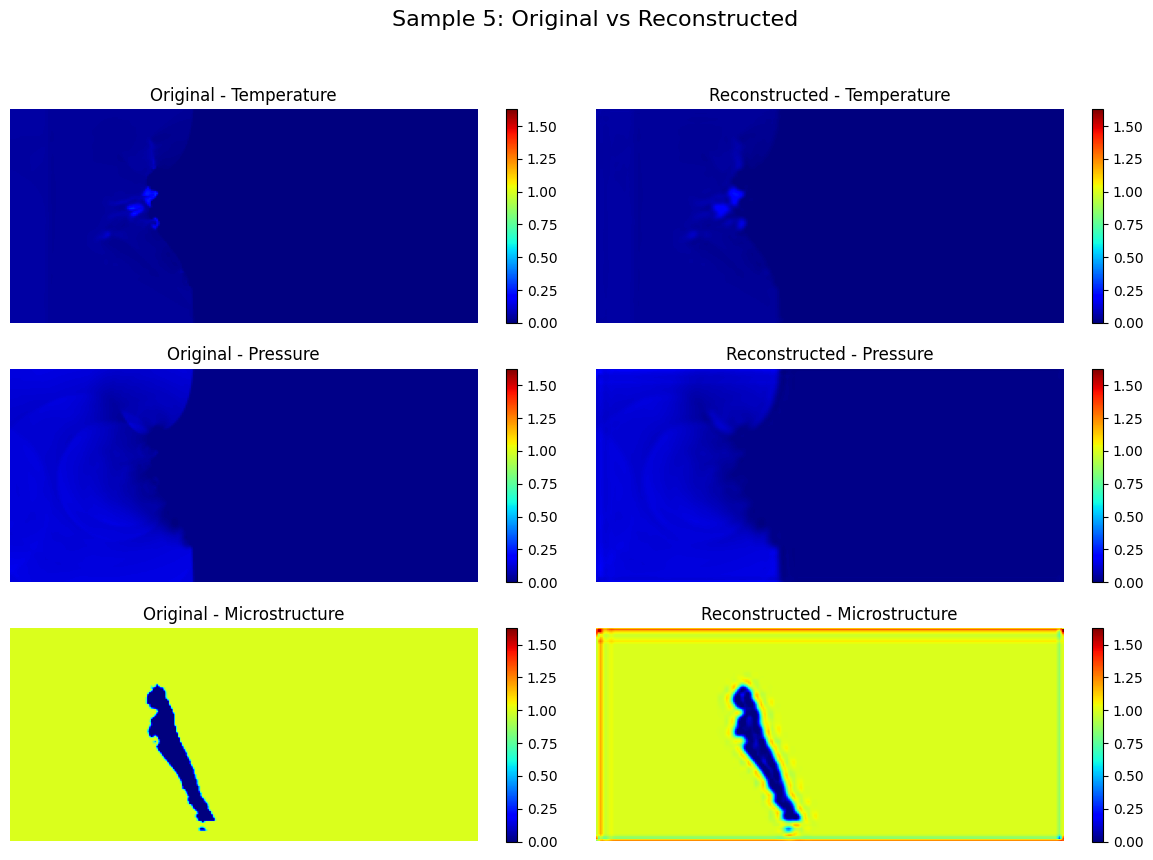

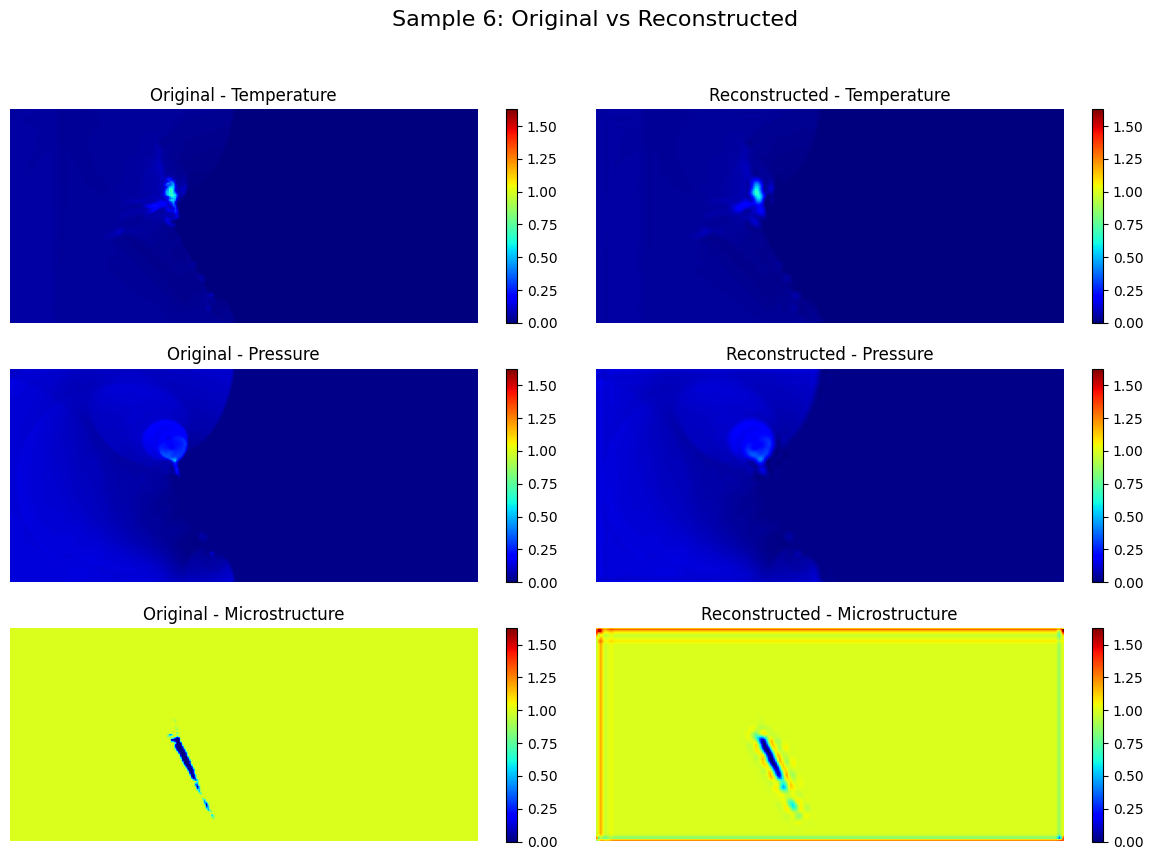

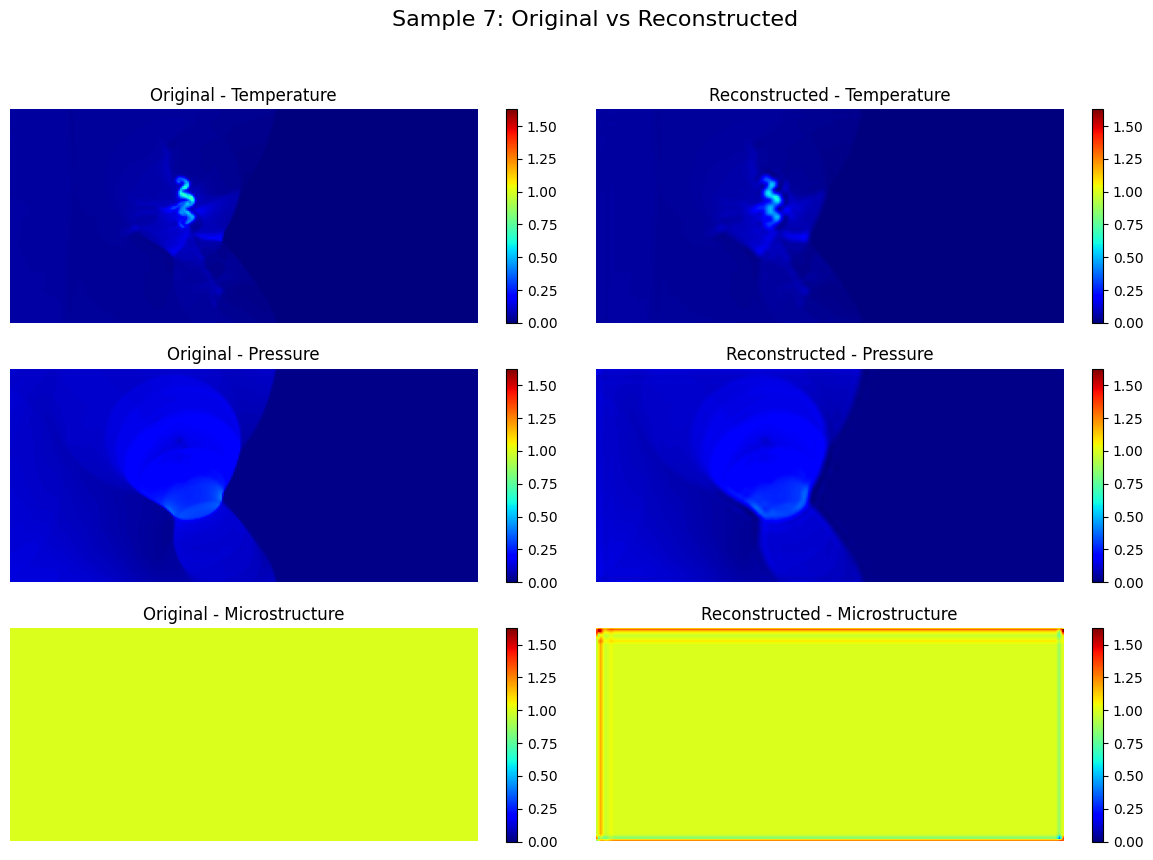

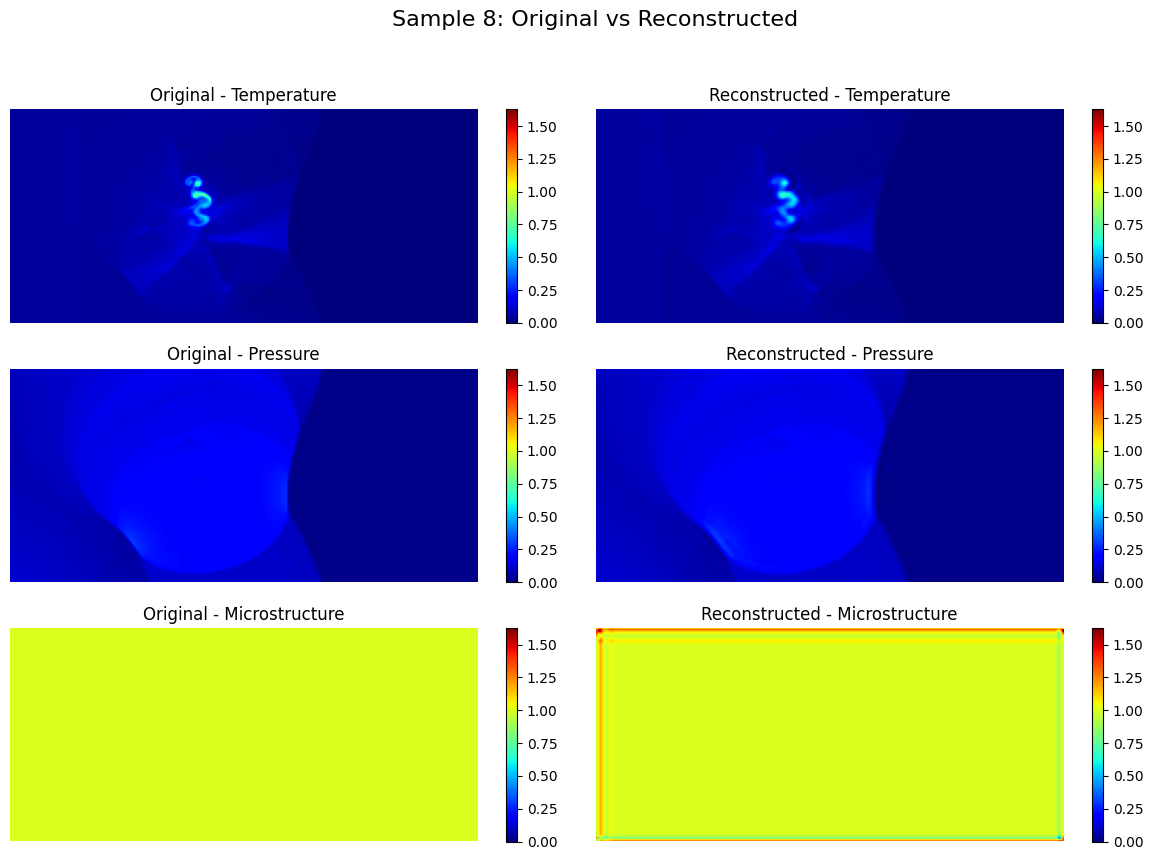

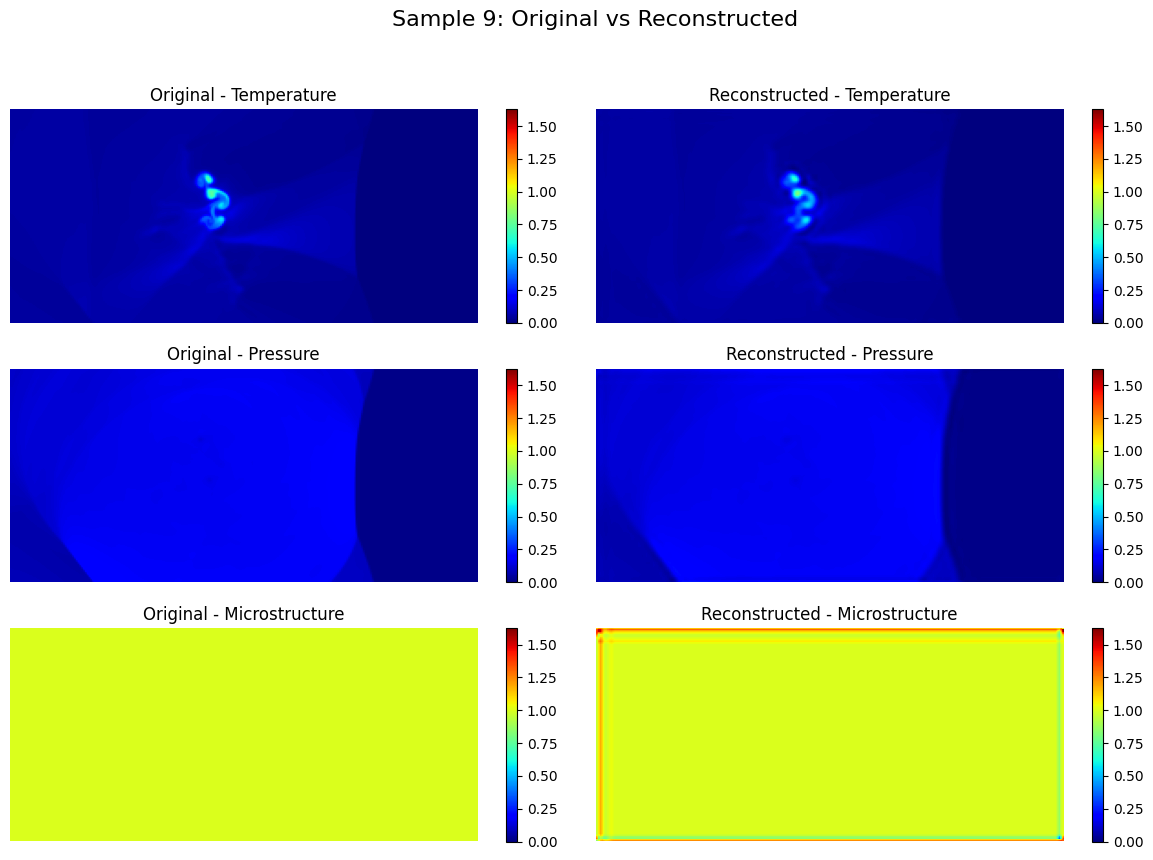

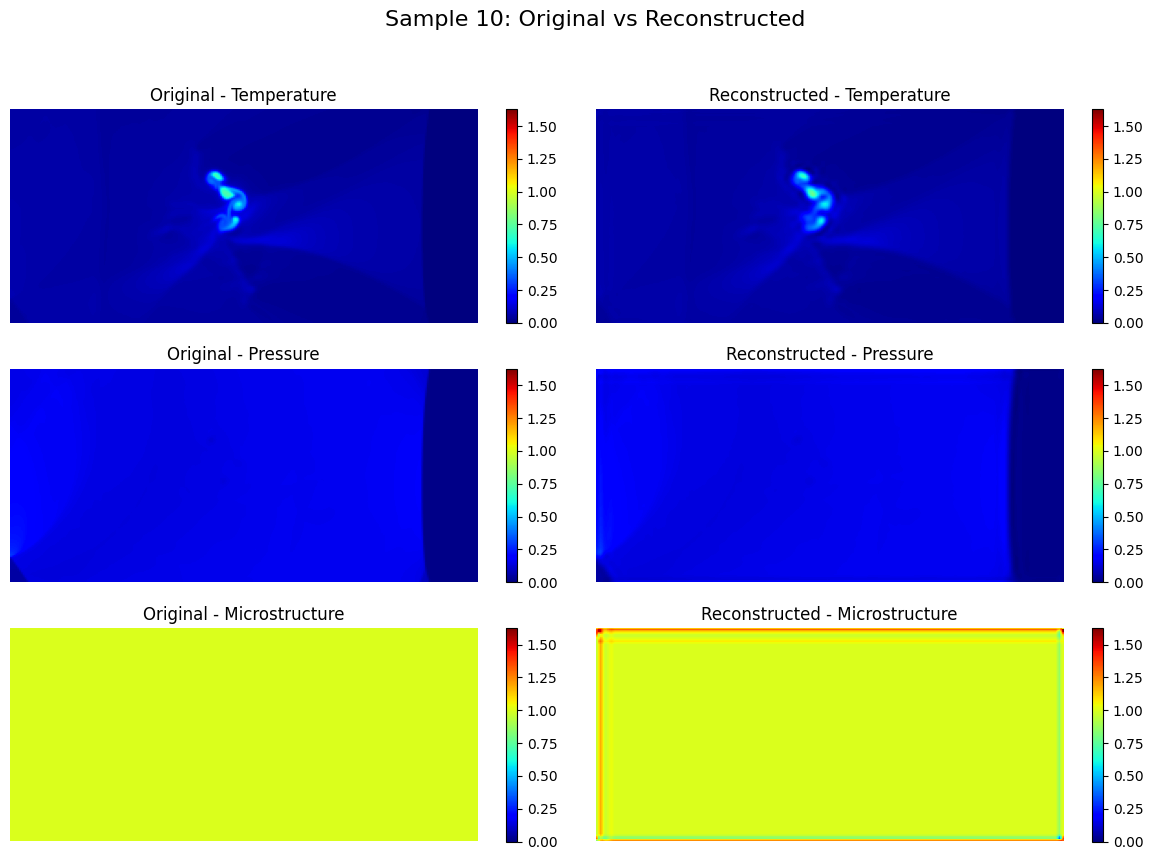

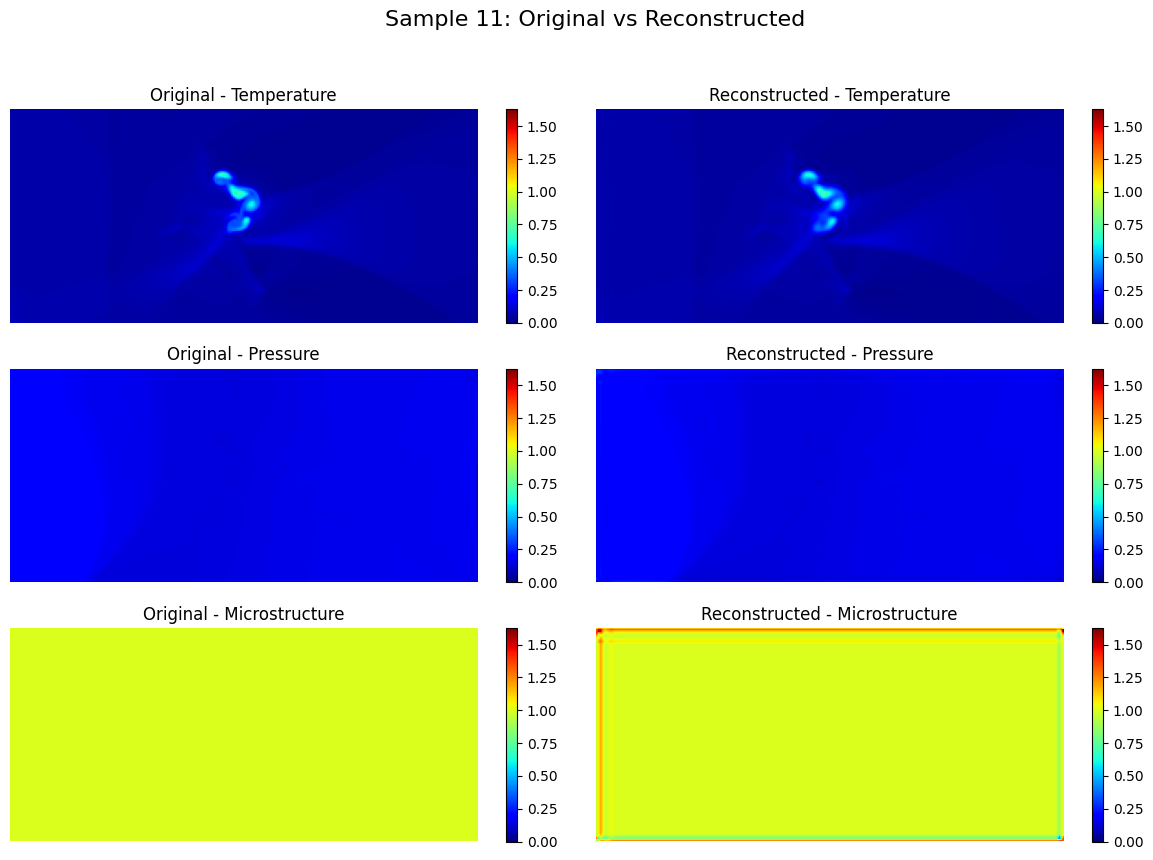

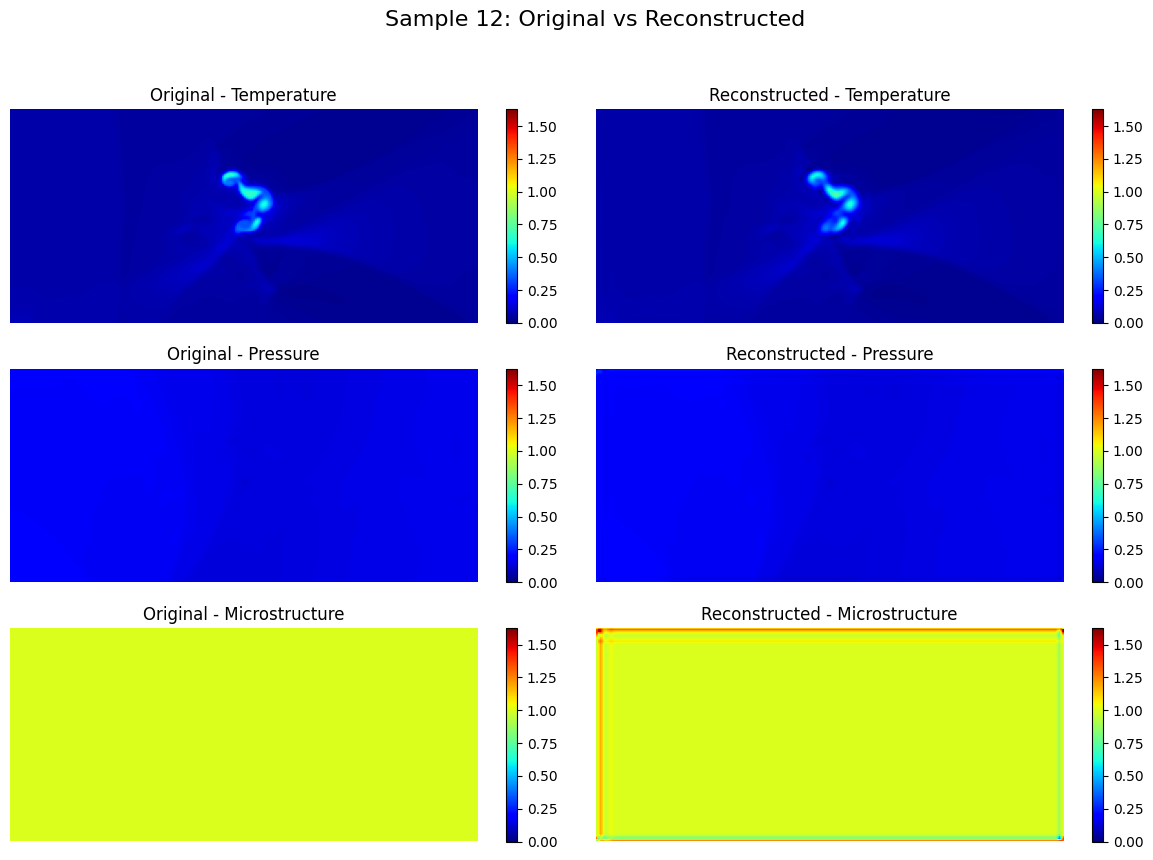

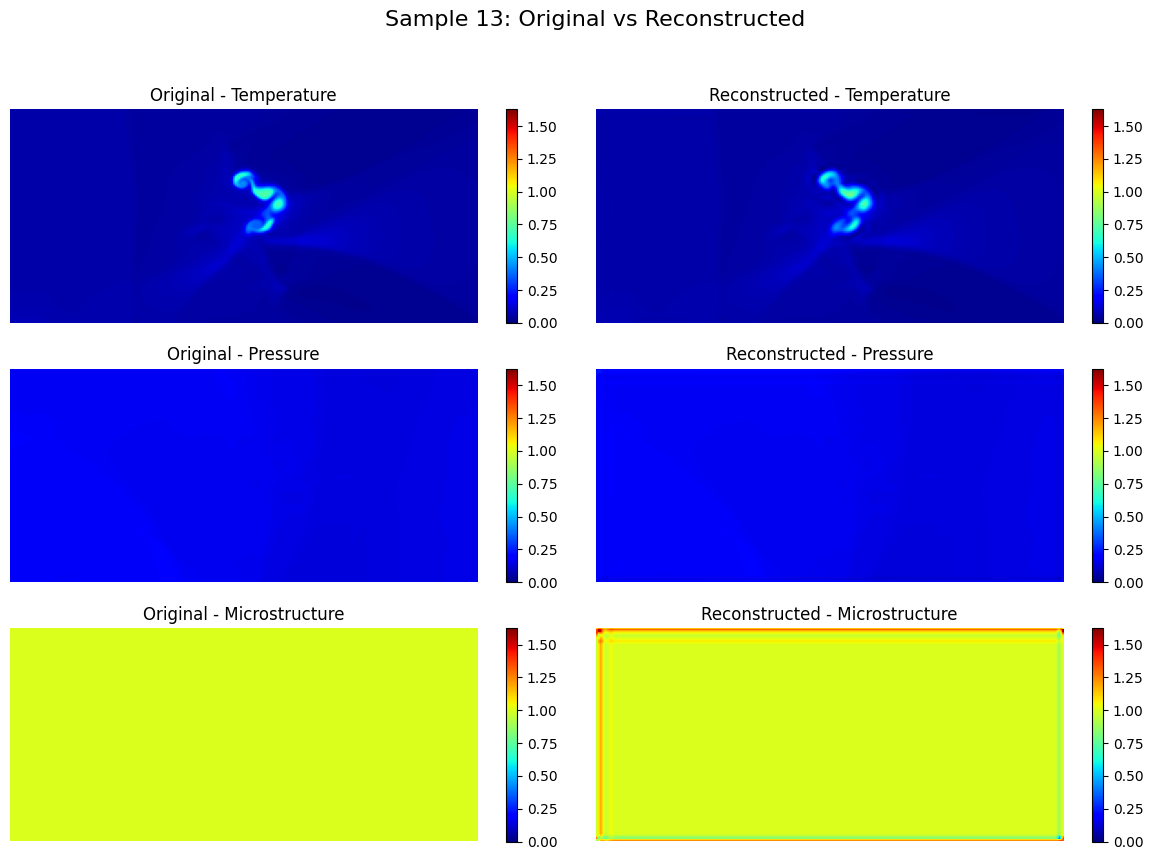

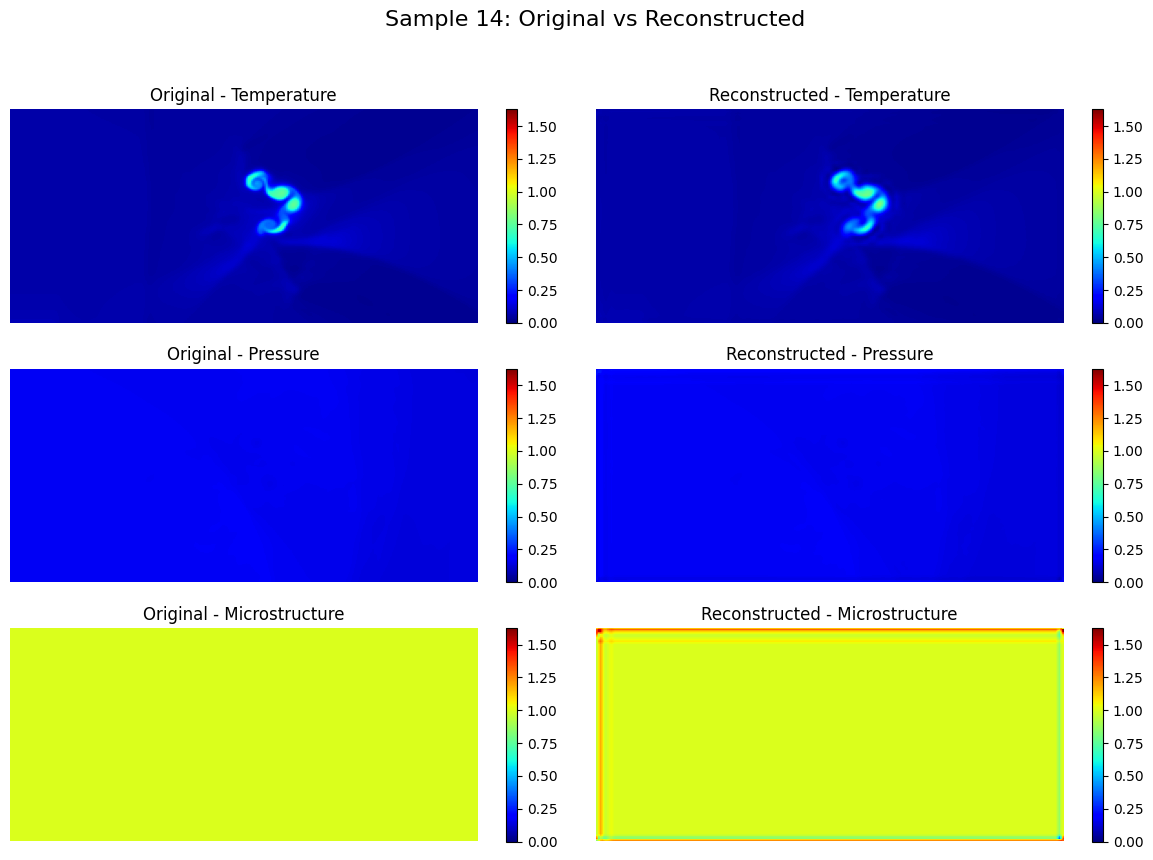

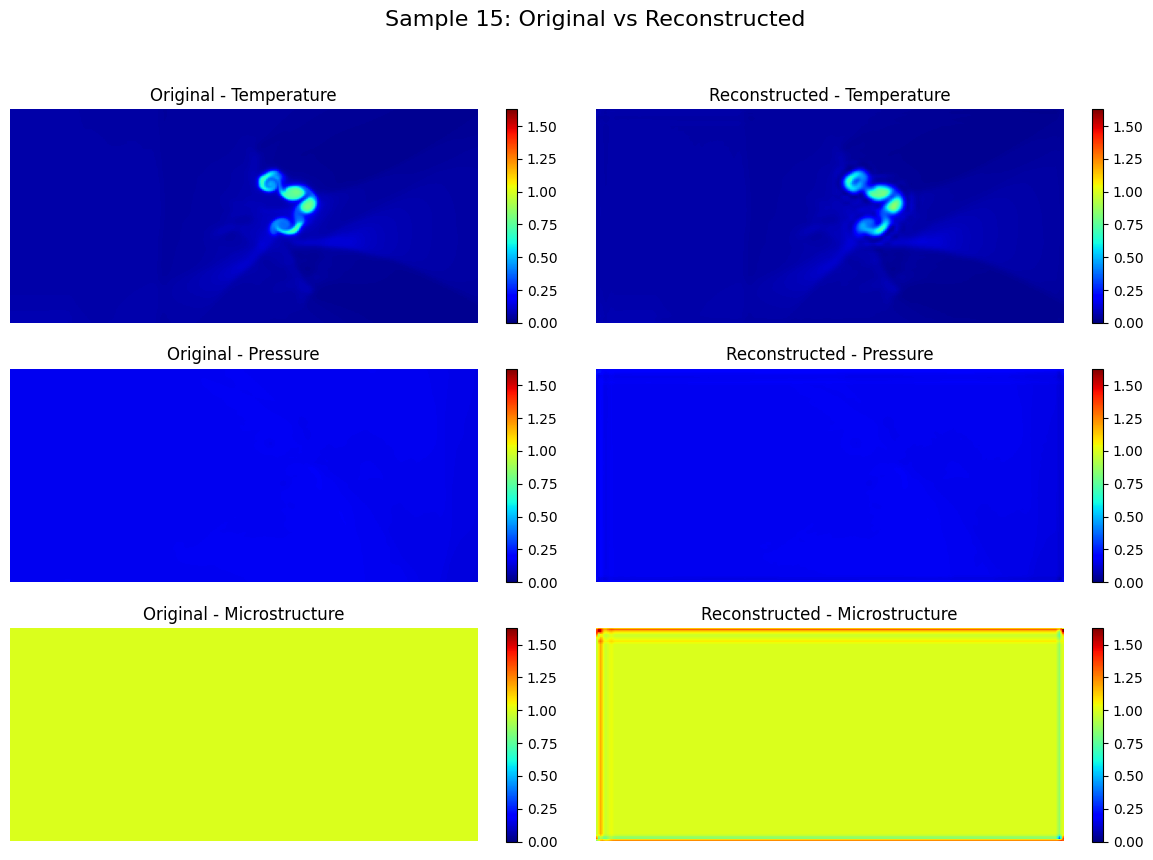

In [18]:
# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

num_samples = n_ts

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(all_test_images.min(), all_reconstructed_images.min())
global_max = max(all_test_images.max(), all_reconstructed_images.max())

# Iterate over the selected samples
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows (channels) x 2 columns (original and reconstructed)
    fig.suptitle(f"Sample {sample_idx + 1}: Original vs Reconstructed", fontsize=16)
    
    # Iterate over the channels
    for channel_idx, channel_name in enumerate(channel_names):
        # Original channel
        original_channel = all_test_images[sample_idx, channel_idx, :, :].numpy()
        # Reconstructed channel
        reconstructed_channel = all_reconstructed_images[sample_idx, channel_idx, :, :].numpy()

        # Plot the original channel
        ax = axes[channel_idx, 0]
        im = ax.imshow(original_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Original - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
        
        # Plot the reconstructed channel
        ax = axes[channel_idx, 1]
        im = ax.imshow(reconstructed_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Reconstructed - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
    plt.show()


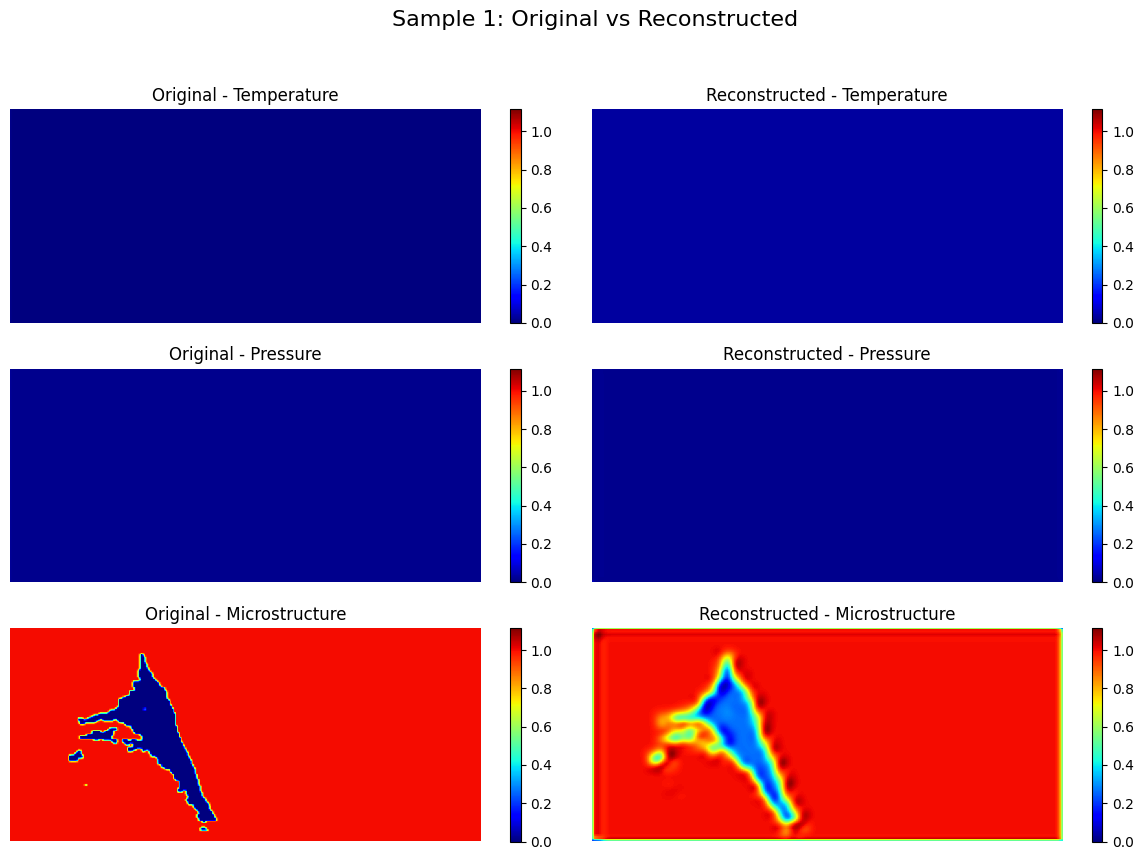

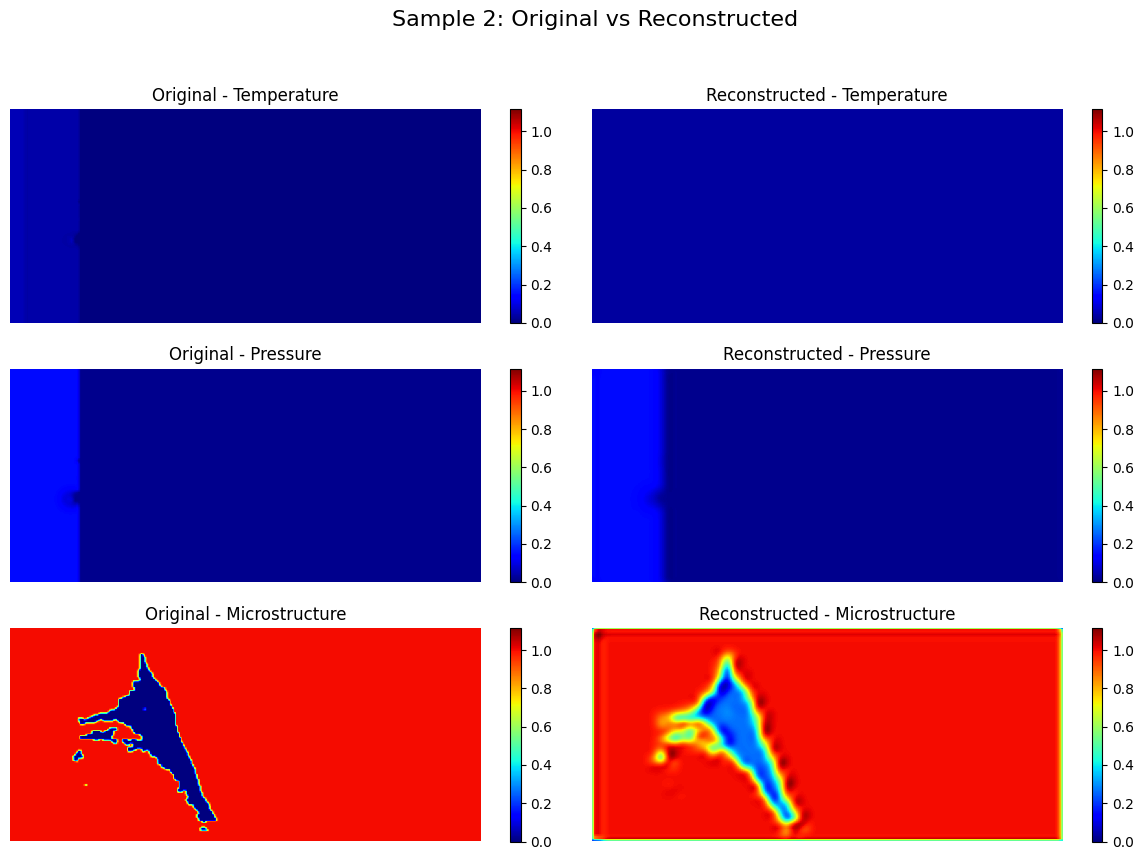

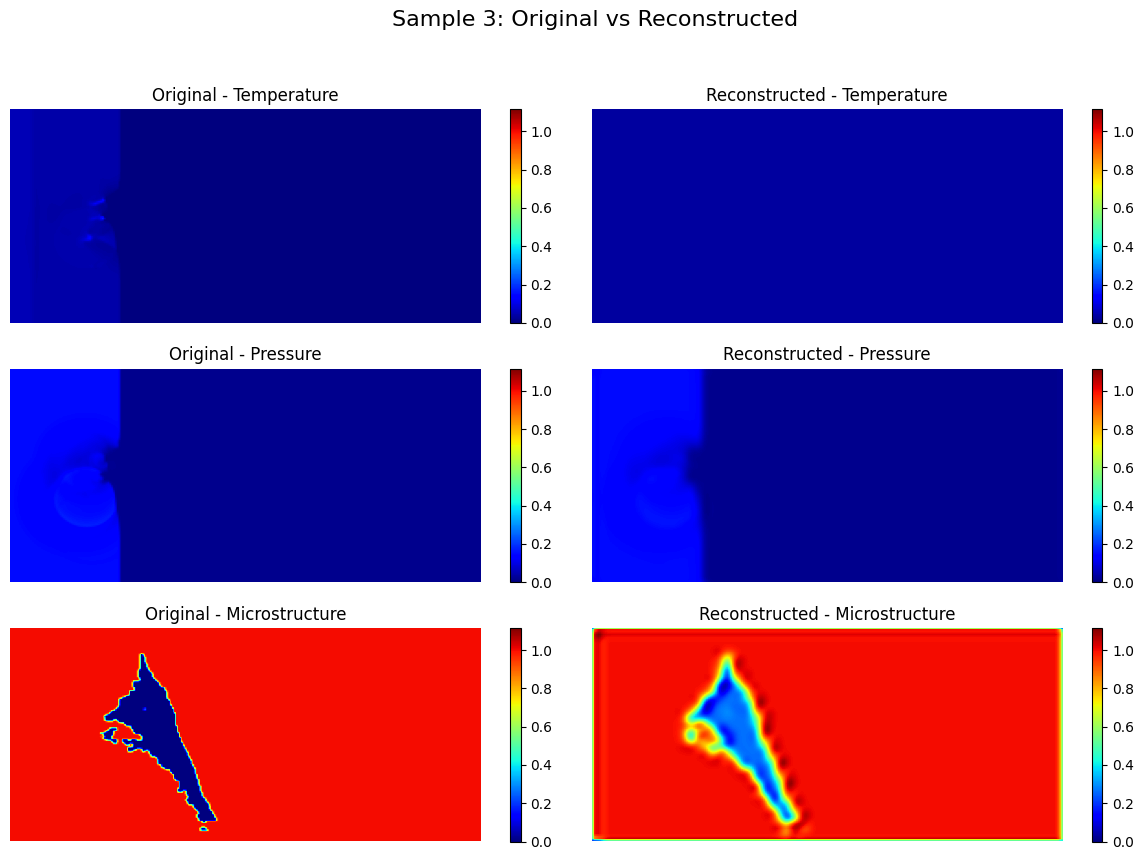

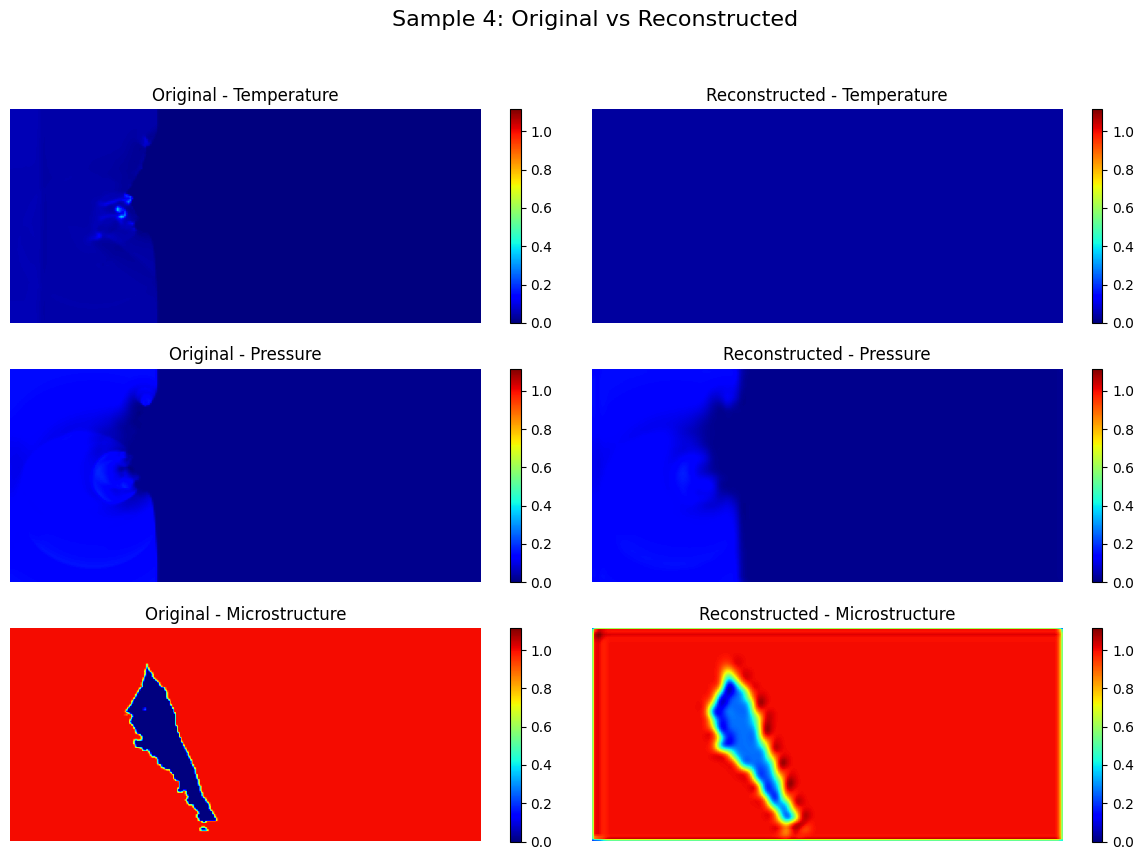

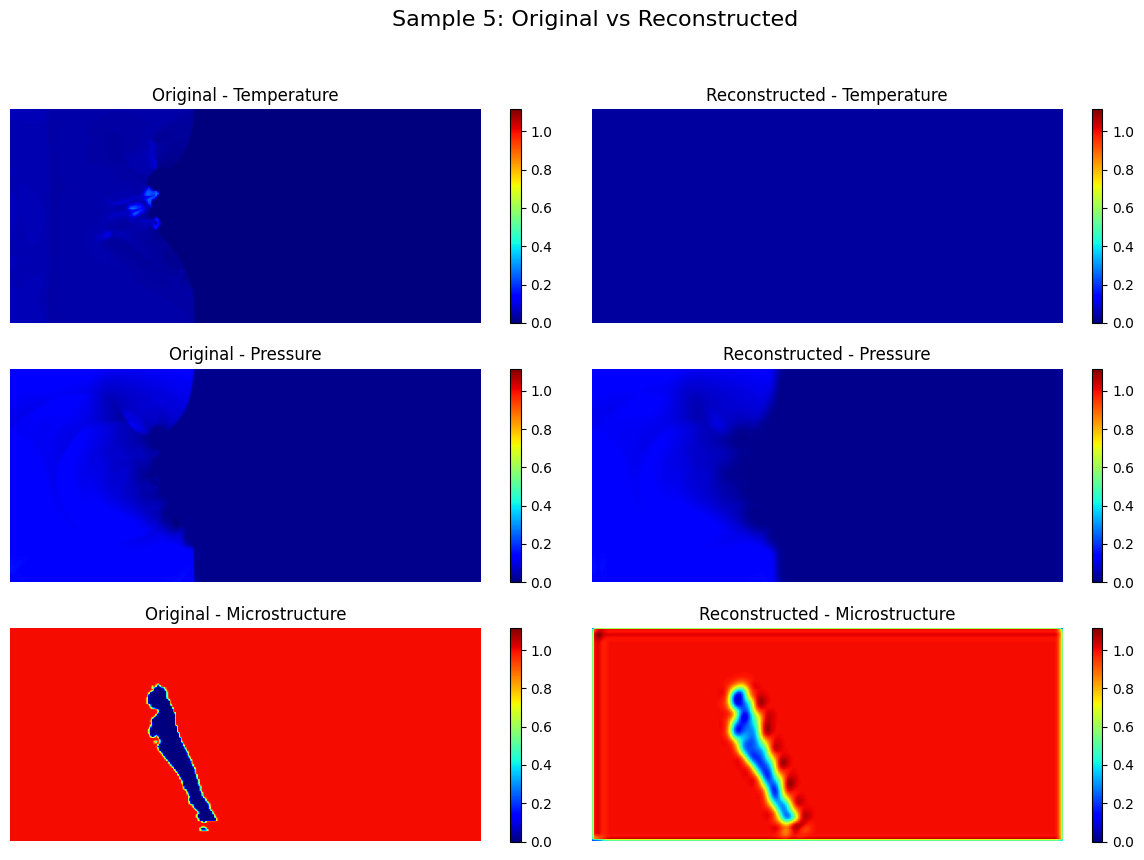

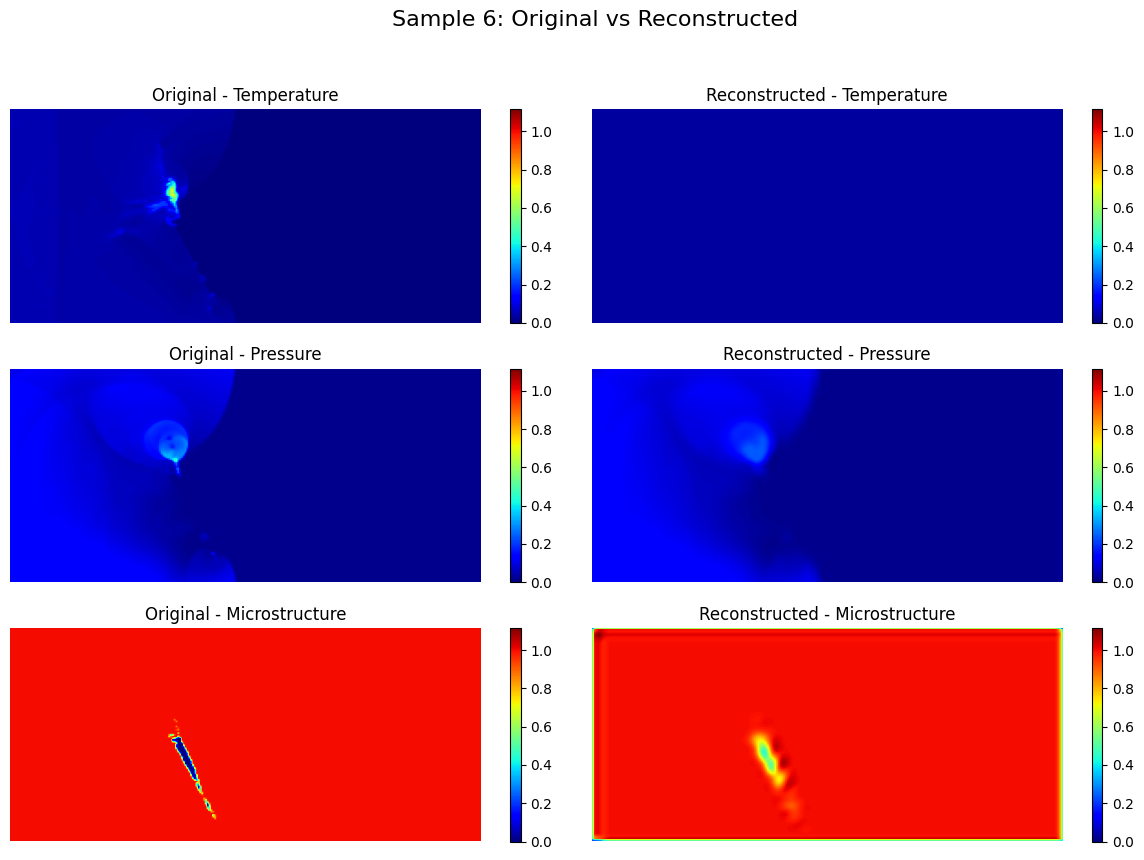

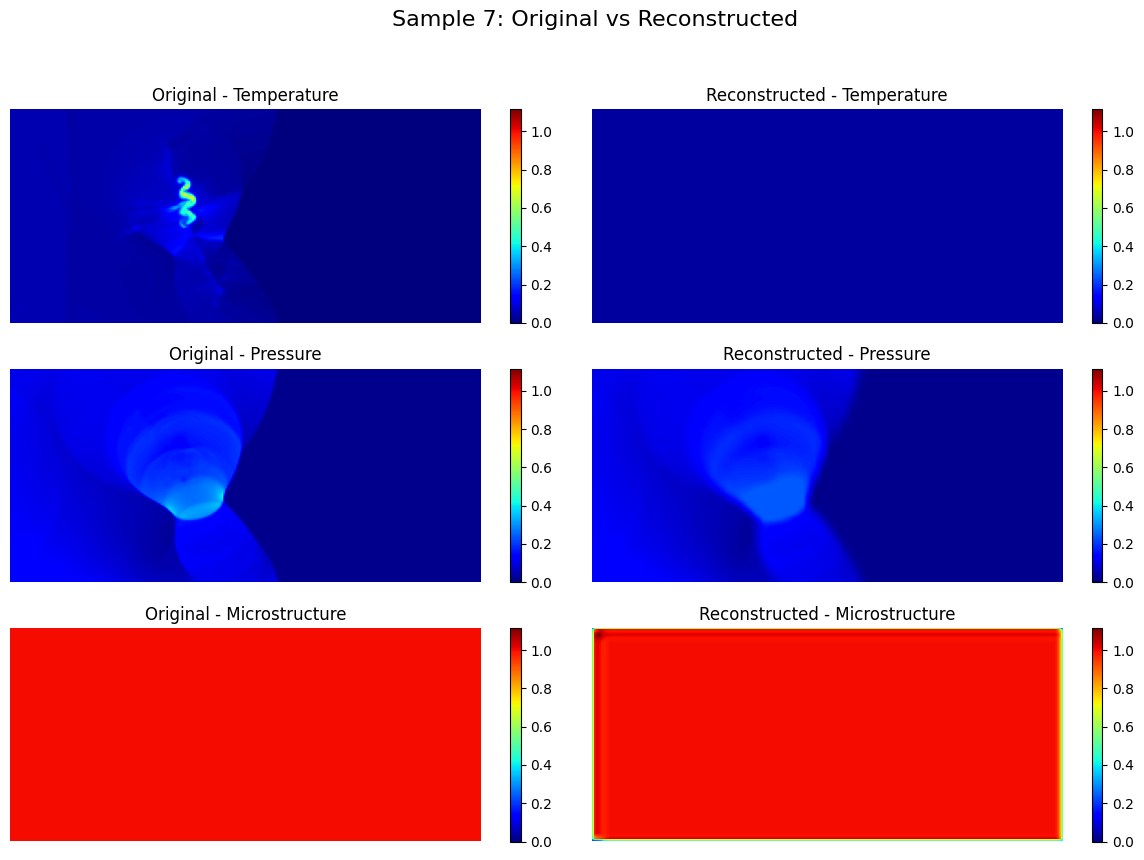

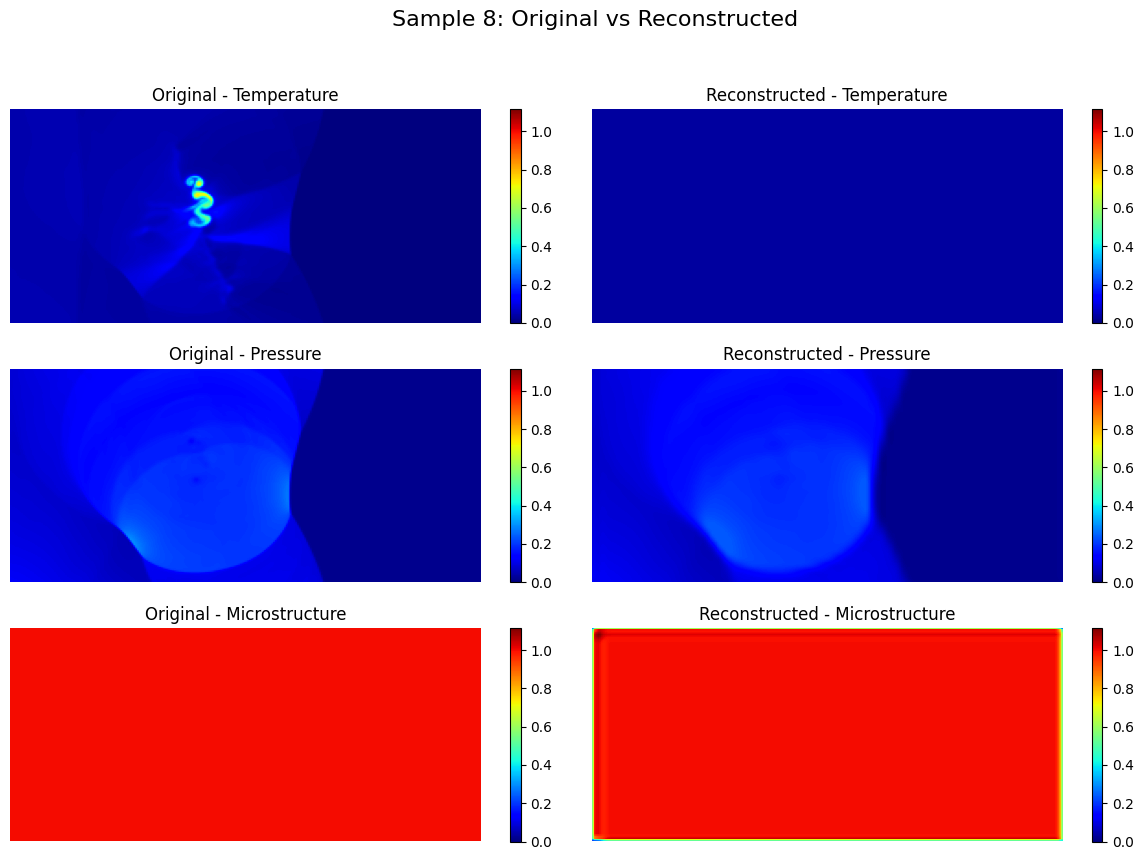

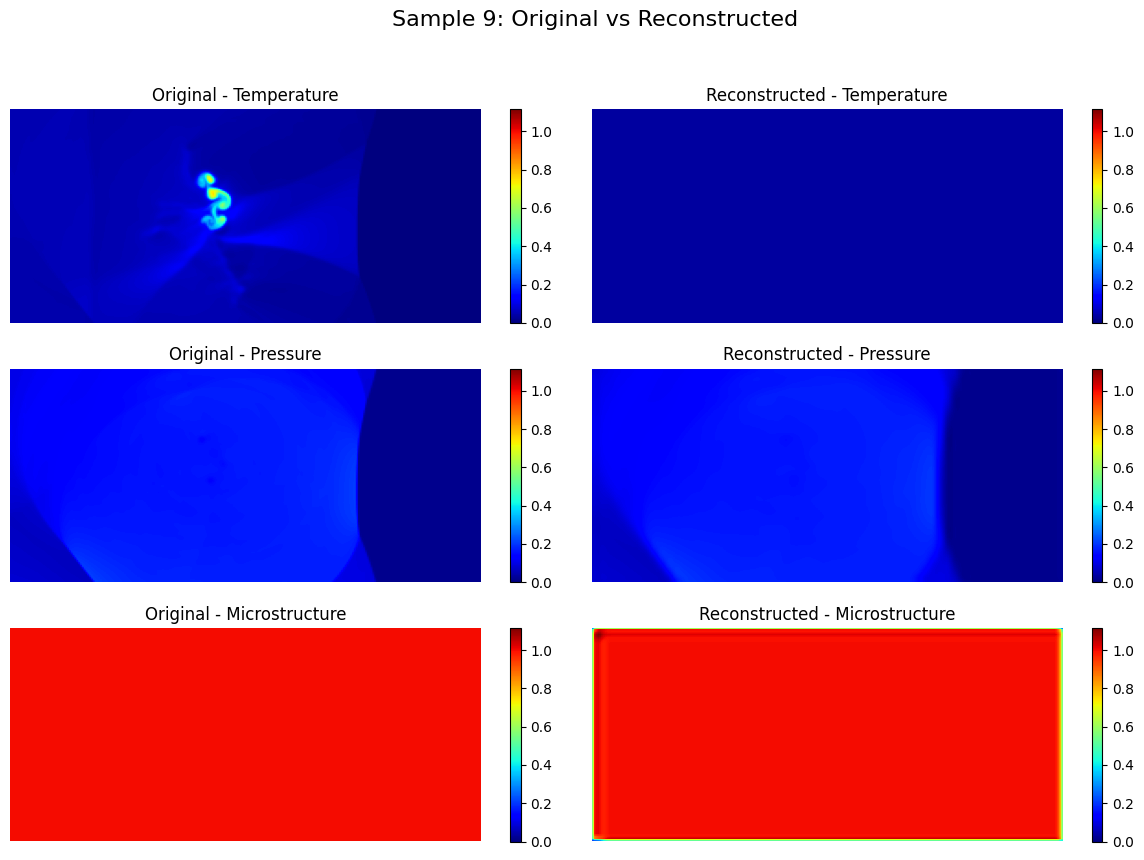

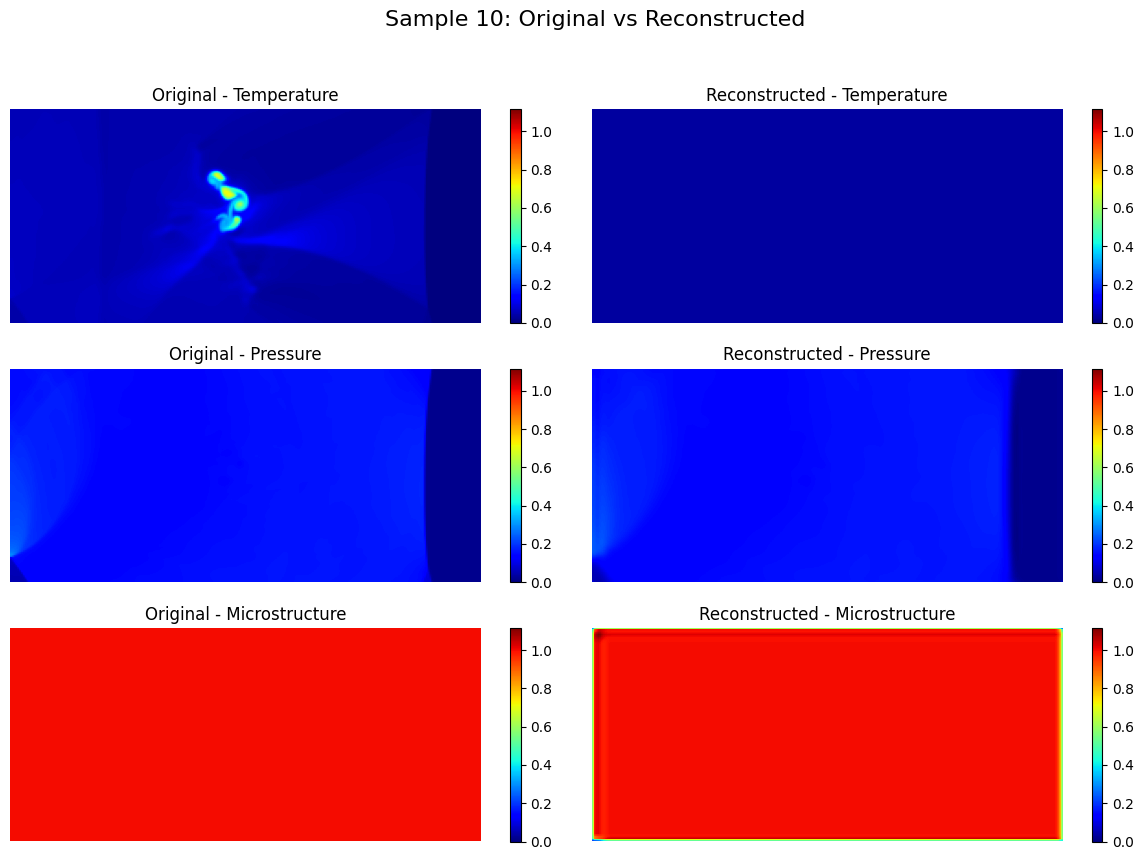

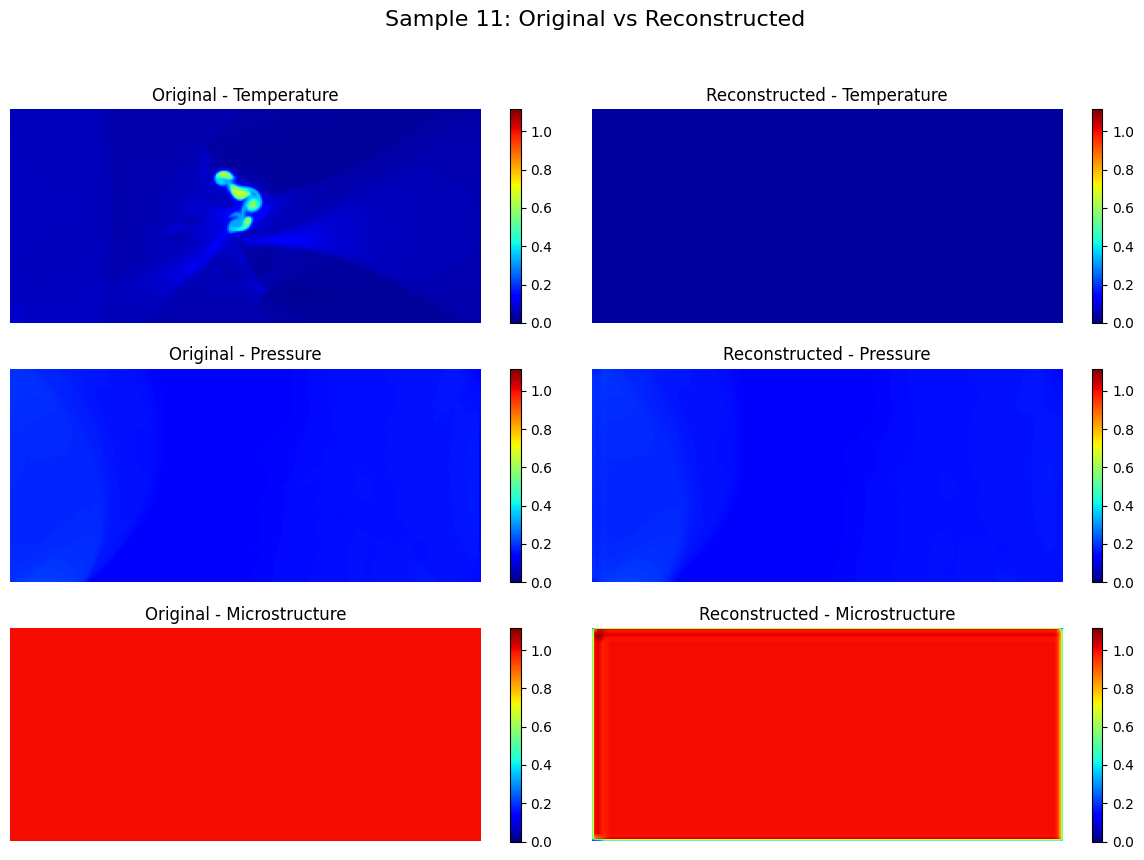

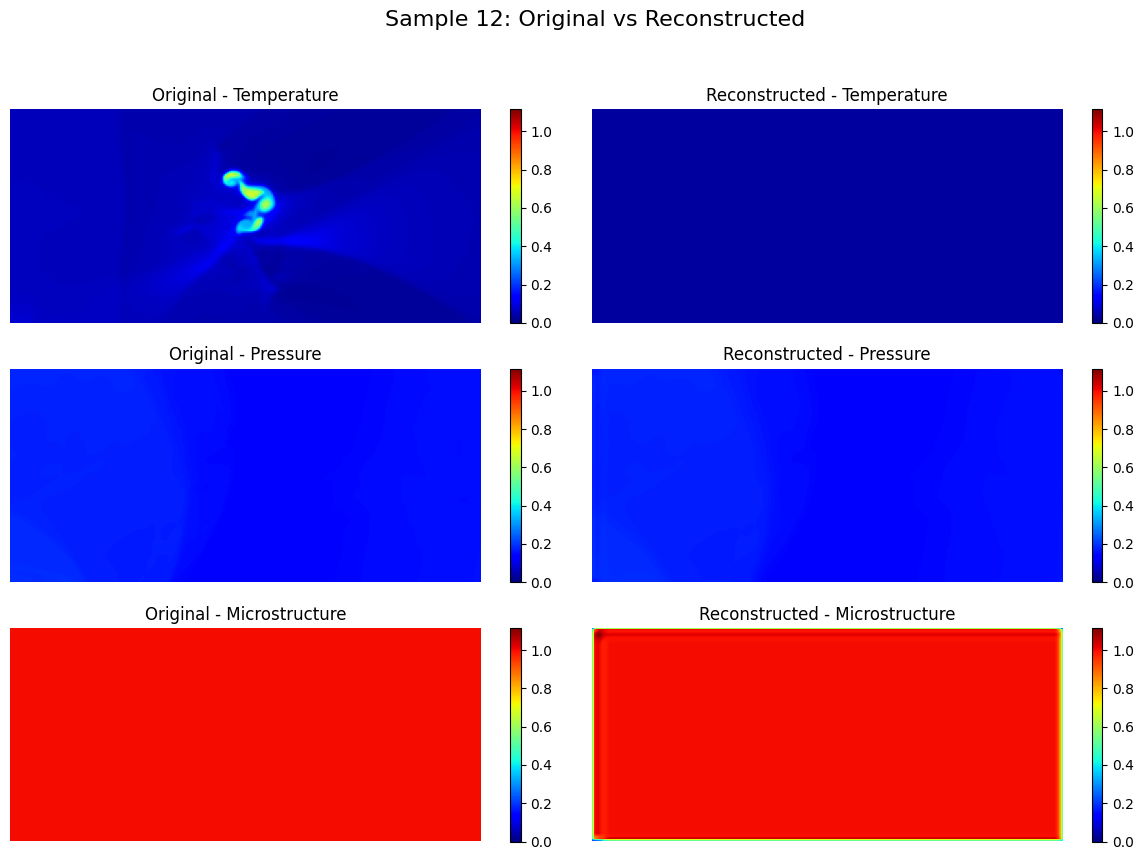

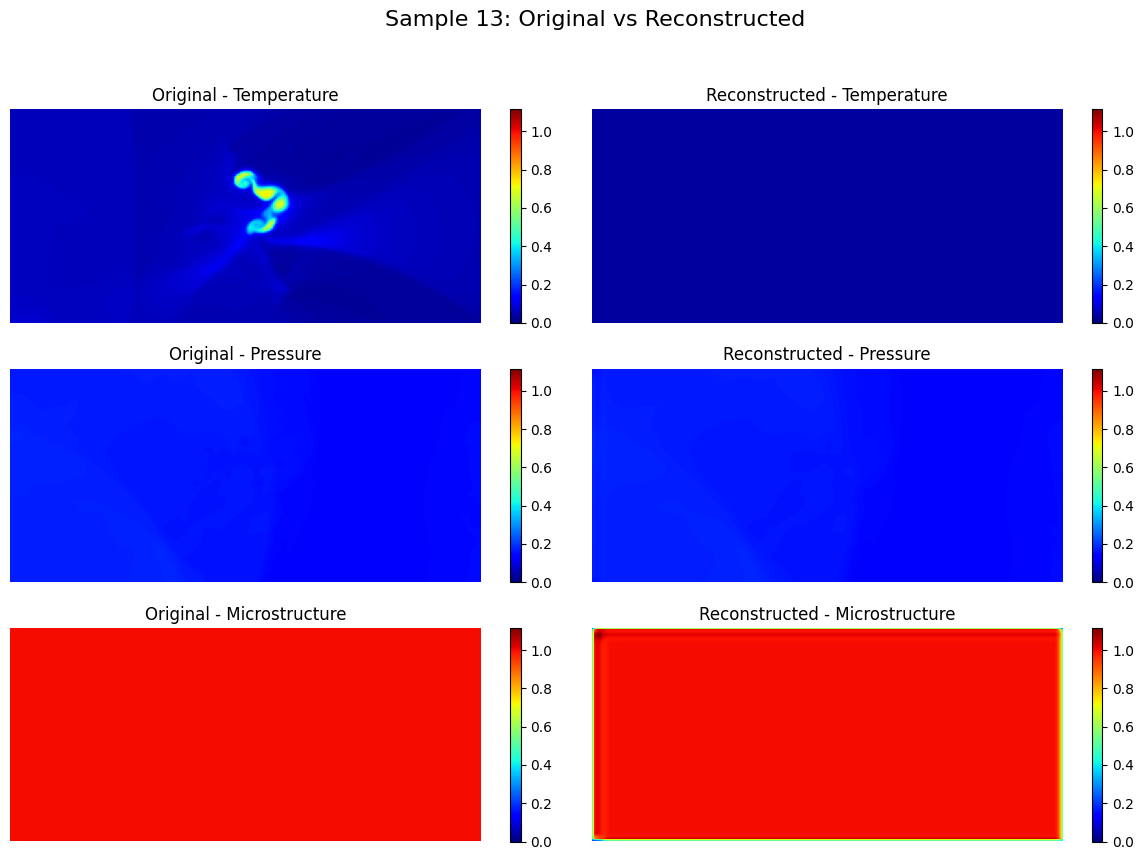

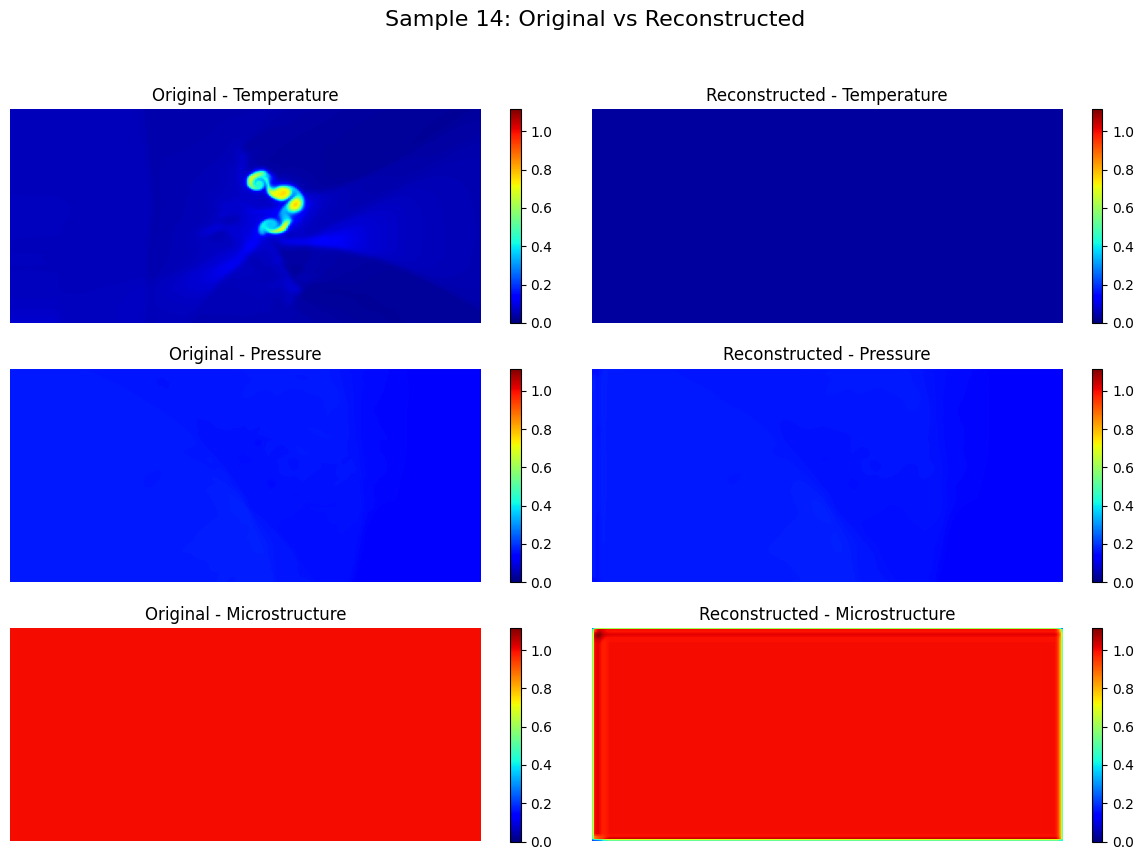

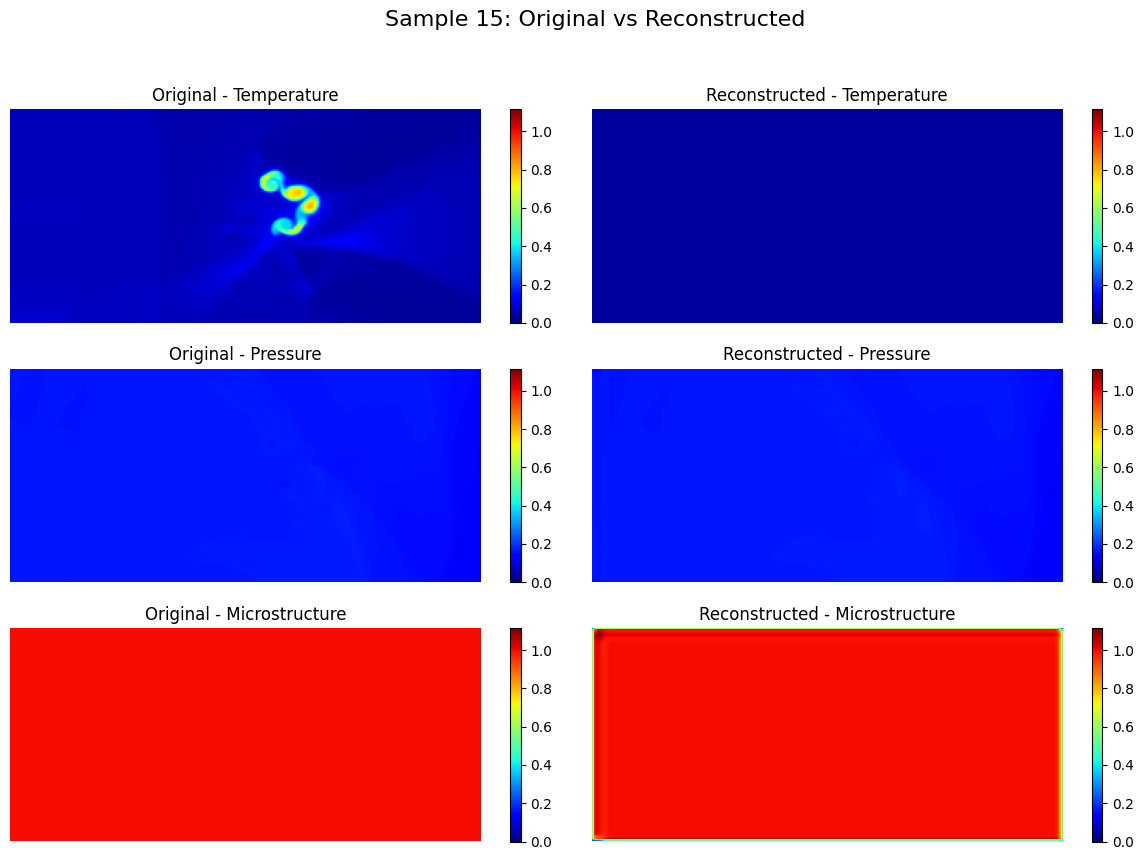

In [10]:
### CLAMPING NEGATIVE VALUES

import numpy as np
import matplotlib.pyplot as plt

# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

num_samples = n_ts  # number of time steps / samples to visualize

# Clamp the data to be >= 0 before calculating global min/max
clipped_test_images = np.clip(all_test_images.numpy(), a_min=0, a_max=None)
clipped_reconstructed_images = np.clip(all_reconstructed_images.numpy(), a_min=0, a_max=None)

# Compute global min and max from the clamped arrays
global_min = min(clipped_test_images.min(), clipped_reconstructed_images.min())
global_max = max(clipped_test_images.max(), clipped_reconstructed_images.max())

# Iterate over the selected samples
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows (channels) x 2 columns (original and reconstructed)
    fig.suptitle(f"Sample {sample_idx + 1}: Original vs Reconstructed", fontsize=16)
    
    # Iterate over the channels
    for channel_idx, channel_name in enumerate(channel_names):
        # Clamp each individual channel
        original_channel = np.clip(clipped_test_images[sample_idx, channel_idx], a_min=0, a_max=None)
        reconstructed_channel = np.clip(clipped_reconstructed_images[sample_idx, channel_idx], a_min=0, a_max=None)

        # Plot the original channel
        ax = axes[channel_idx, 0]
        im = ax.imshow(original_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Original - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)

        # Plot the reconstructed channel
        ax = axes[channel_idx, 1]
        im = ax.imshow(reconstructed_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Reconstructed - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the main title
    plt.show()


## GIFs

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

file_name = "notpopped_dec_vertflip_layers_1_2_latent_4_MSE_DE_Nmax16_nrf8_redon10_LRplateau_e3_factor8_pat10_T_500"
plot_name = "L1LOSS 3 8 latent 8 AE Pred., No Dynamics, 2 Test Samples, 1000 Epochs"

# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

# Number of samples to show (ensure it's less than the total number of test images)
num_samples = n_ts

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(all_test_images.min(), all_reconstructed_images.min())
global_max = max(all_test_images.max(), all_reconstructed_images.max())

frames = []  # List to store frames for GIF

# Iterate over the selected samples (each sample represents a time step)
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(2, 3, figsize=(6, 4), dpi=150, constrained_layout=True)  # Reduced figsize and dpi for smaller GIF
    fig.suptitle(plot_name, fontsize=12)  # Reduced font size for title
    
    for channel_idx, channel_name in enumerate(channel_names):
        original_channel = all_test_images[sample_idx, channel_idx, :, :].numpy()
        reconstructed_channel = all_reconstructed_images[sample_idx, channel_idx, :, :].numpy()
        
        # Plot original
        ax = axes[0, channel_idx]
        ax.imshow(original_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (GT)", fontsize=10)  # Smaller title font size
        ax.axis("off")
        
        # Plot reconstructed
        ax = axes[1, channel_idx]
        ax.imshow(reconstructed_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (Pred)", fontsize=10)  # Smaller title font size
        ax.axis("off")
    
    # Convert the figure to a PIL Image and append to frames
    fig.canvas.draw()  # Draw the figure onto the canvas
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))  # Reshape to image dimensions
    frames.append(Image.fromarray(img))

    plt.close(fig)

# Check if frames are created successfully
if len(frames) == 0:
    print("Error: No frames generated!")
else:
    # Save frames as GIF
    gif_path = file_name + ".gif"
    try:
        frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0)
        print(f"GIF saved to {gif_path}")
    except Exception as e:
        print(f"Error saving GIF: {e}")


/tmp/ipykernel_241185/288420982.py:43: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


GIF saved to notpopped_dec_vertflip_layers_1_2_latent_4_MSE_DE_Nmax16_nrf8_redon10_LRplateau_e3_factor8_pat10_T_500.gif


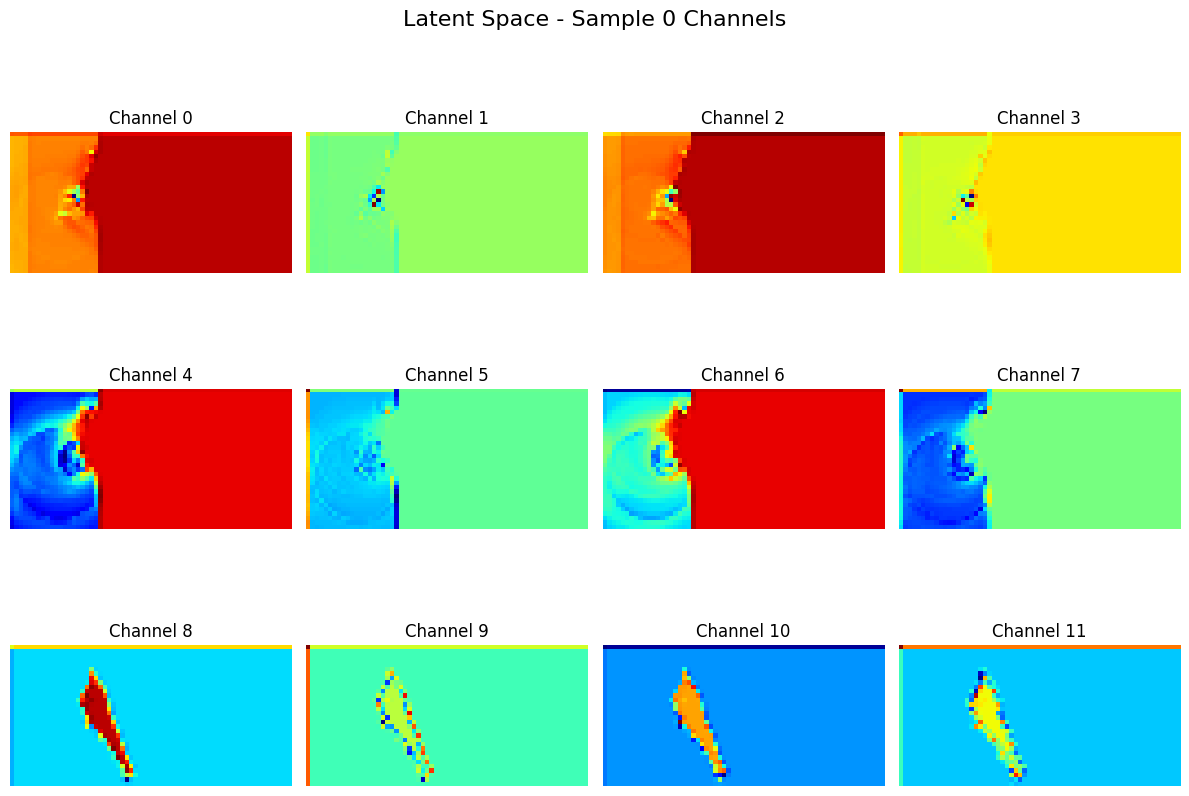

In [20]:
ts_idx = 3 # pick which time step you want to visualize


latentT = autoencoder.encoderT(all_test_images[ts_idx, ...][0, ...].unsqueeze(0).to(device))
latentP = autoencoder.encoderP(all_test_images[ts_idx, ...][1, ...].unsqueeze(0).to(device))
latentM = autoencoder.encoderM(all_test_images[ts_idx, ...][2, ...].unsqueeze(0).to(device))

latent = torch.cat((latentT, latentP, latentM), dim=0) # concat in latent space (batch, channel, H, W)  

n_channels = latent.shape[0]
n_rows, n_cols = 3, latent_dim

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
fig.suptitle('Latent Space - Sample 0 Channels', fontsize=16)

for ch, ax in enumerate(axes.flat):
    img = latent[ch].detach().cpu().numpy()  # shape: [32, 64]
    im = ax.imshow(img, cmap='jet')
    ax.set_title(f'Channel {ch}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Loss Plots

In [22]:
import json
import matplotlib.pyplot as plt

filename = 'notpopped_dec_vertflip_layers_1_2_latent_4_MSE_DE_Nmax16_nrf8_redon10_LRplateau_e3_factor8_pat10'
n_epochs = 500

# Define paths to all three JSON logs
log_paths = {
    "T": f"{filename}_T_{n_epochs}.json",
    "P": f"{filename}_P_{n_epochs}.json",
    "M": f"{filename}_M_{n_epochs}.json"
}

# Color map for each channel
colors = {
    "T": "blue",
    "P": "green",
    "M": "orange"
}

# Load logs and extract losses
logs = {}
for key, path in log_paths.items():
    with open(path, 'r') as f:
        log = json.load(f)
    logs[key] = {
        "train": log["training_loss_per_epoch"],
        "val": log["validation_loss_per_epoch"]
    }

# Plot all training and validation losses
fig, ax = plt.subplots(figsize=(10, 6))

for key in logs:
    ax.plot(logs[key]["train"], label=f"{key} Train", linestyle='-', color=colors[key])
    ax.plot(logs[key]["val"], label=f"{key} Val", linestyle='--', color=colors[key])

# Add titles, labels, legend
ax.set_title("Training and Validation Losses for T, P, M", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'notpopped_dec_vertflip_layers_1_2_latent_4_MSE_DE_Nmax16_nrf8_redon10_LRplateau_e3_factor8_pat10_P_500.json'

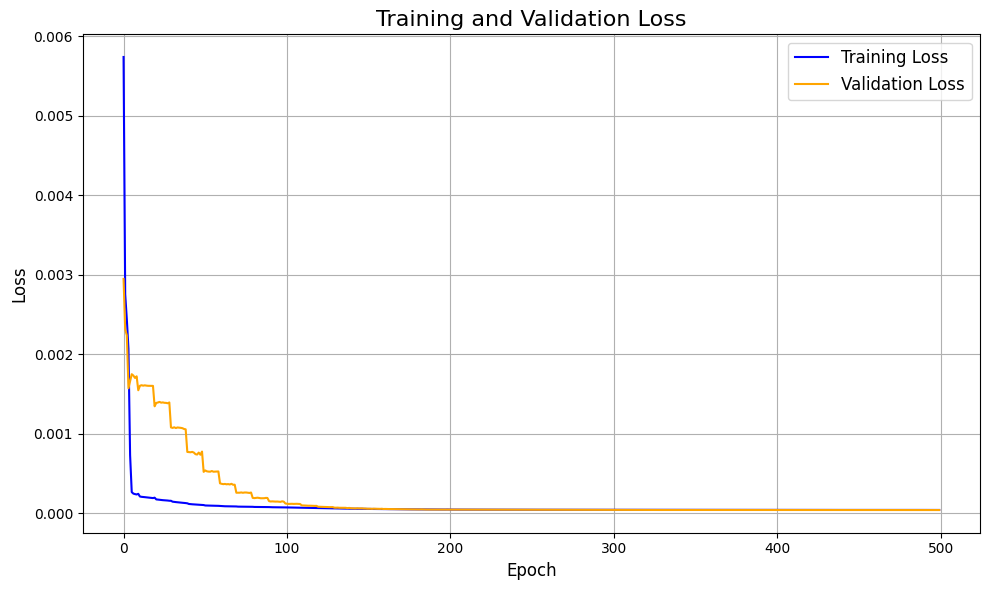

In [23]:
# Path to the JSON log file
log_file_path = "notpopped_dec_vertflip_layers_1_2_latent_4_MSE_DE_Nmax16_nrf8_redon10_LRplateau_e3_factor8_pat10_T_500.json"

# Load the log data
with open(log_file_path, 'r') as f:
    log_dict = json.load(f)

# Extract training and validation loss
training_loss = log_dict['training_loss_per_epoch']
validation_loss = log_dict['validation_loss_per_epoch']

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(training_loss, label="Training Loss", color="blue")
ax.plot(validation_loss, label="Validation Loss", color="orange")

# Add titles, labels, and legend
ax.set_title("Training and Validation Loss", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


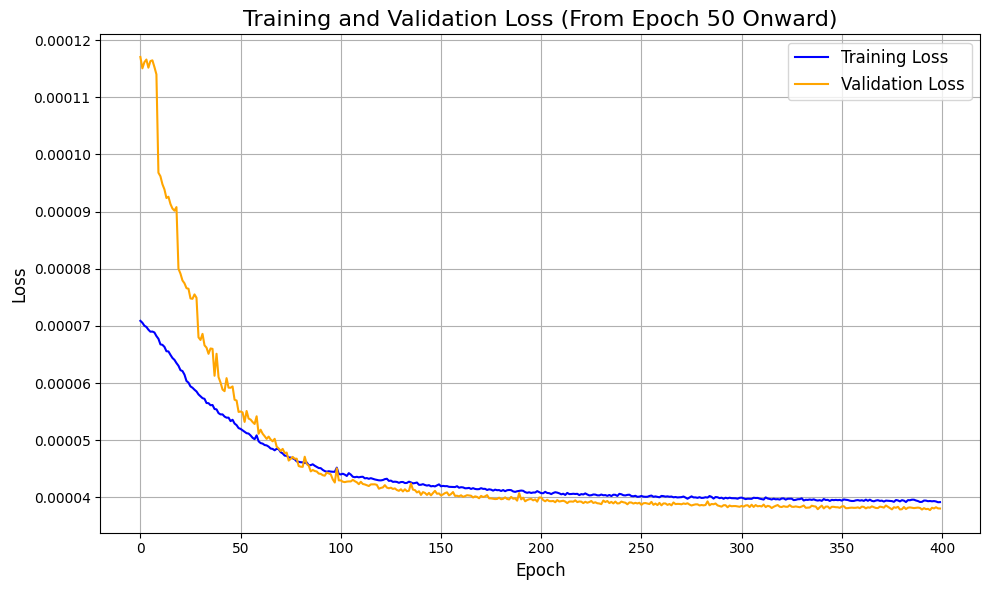

In [25]:
# Starting from the 50th epoch (index 49, since indexing starts at 0)
start_epoch = 50

# Slice the data from the 50th epoch onward
training_loss = training_loss[start_epoch:]
validation_loss = validation_loss[start_epoch:]

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(training_loss, label="Training Loss", color="blue")
ax.plot(validation_loss, label="Validation Loss", color="orange")

# Add titles, labels, and legend
ax.set_title(f"Training and Validation Loss (From Epoch {start_epoch} Onward)", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
